In [29]:
#What happens if the model is trained on 365 fake pdf (instead of 12 pdf)  ---> Impressive


from transformers import LayoutLMv3Tokenizer,LayoutLMv3FeatureExtractor,LayoutLMv3ForTokenClassification,AutoModelForTokenClassification,AutoProcessor
import pandas as pd
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from PIL import Image, ImageDraw, Image, ImageFont, ImageColor, ImageOps
from sklearn.utils import shuffle
import random

In [2]:
model = AutoModelForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=14)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimiser = AdamW(model.parameters(), lr=6e-5)
scheduler = StepLR(optimiser, step_size=1, gamma=0.85)
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
feature_extractor = LayoutLMv3FeatureExtractor()
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

In [4]:

company = [163,92,1569,166]
job = [163,92,1569,166]
ssn =[174,226,1179,292]
resident = [266, 295, 1577, 355]
location = [353,361,1590,437]
blood_group = [298,421,400,495]
website = [226,495,1403,564]
username = [255, 561,1377, 617]
name = [189, 619, 1345, 685]
sex = [158, 690, 261, 762]
address = [224, 762, 944,851]
mail = [179, 833, 511, 888]
birthday = [234, 893, 443, 967]
description = [68, 1062, 1627,2307]

annotation_dict = {
    'job':job,
    'company':company,
    'ssn':ssn,
    'resident':resident,
    'location': location,
    'blood_group': blood_group,
    'website':website,
    'username':username,
    'sex':sex,
    'address': address,
    'mail':mail,
    'birthday':birthday,
    'description':description
}


In [5]:
def generateonefakeppdf():
    from faker import Faker
    import warnings
    warnings.filterwarnings('ignore')
    from fpdf import FPDF
    import pdf2image
    fake = Faker()
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('helvetica', size=12)
    profile = fake.profile()
    profile.keys()
    for k in profile.keys():
        try:
            pdf.cell(txt=' ',ln=1)
            pdf.cell(txt=f'{k.capitalize()}:')
            pdf.cell(txt= f' {profile[k]}',ln=1)
        except:
            pass
    pdf.cell(txt=' ',ln=1)
    pdf.cell(0, 10, 'Description', 0, 0, 'C')
    pdf.ln(10)
    pdf.cell(txt=' ',ln=1)
    pdf.cell(txt= fake.catch_phrase(),ln=1)
    pdf.cell(txt=' ',ln=1)
    for p in fake.paragraphs():
        pdf.multi_cell(align='l',txt=p,w=200,ln=1)
        pdf.cell(txt=' ',ln=1)

    pdf.output(f"fakepdf.pdf")
    image = pdf2image.convert_from_path('fakepdf.pdf')[0]
    return image 

In [6]:
def automatefakelabelling(label,words,boxes,hh,ww):
    X1,Y1,X2,Y2 = annotation_dict[label]
    W =[]
    B = []
    for w,b in zip(words,boxes):
        b_ = unnormalize_box(b,ww,hh)
        b_ = [int(a) for a in b_]
        x1,y1,x2,y2 = b_
        xx1 = min(X1, X2) - x1
        xx2 = max(X1, X2) - x2
        yy1 = min(Y1, Y2) - y1
        yy2 = max(Y1, Y2) - y2
        if xx1 <= 0 and yy1 <= 0 and xx2 >= 0 and yy2 >= 0:
            W.append(w)
            B.append(b)
    return W,B
        

In [7]:
labels = annotation_dict.keys()
label2dict = {}
dict2label = {}
for label, n in zip(labels, [i for i in range(len(labels))]):
    label2dict[label] = n
    dict2label[n] = label

def generatefakeimageandannotation(image):
    encoding = feature_extractor(image, return_tensors="pt")
    words = encoding['words'][0]
    boxes = encoding['boxes'][0]
    hh,ww = image.height,image.width
    W =[]
    B =[]
    L = []
    for k in annotation_dict.keys():
        w_,b_ = automatefakelabelling(k,words,boxes,hh,ww)
        W.append(w_)
        B.append(b_)
        for k_ in [k for _ in range(len(w_))]:
            L.append(k)
    W_ = []
    B_ = []
    for w,b in zip(W,B):
        for ww,bb in zip(w,b):
            W_.append(ww)
            B_.append(bb)
    L = [label2dict[l] for l in L]   
    return W_,B_,L,image

In [8]:
def generateencoder():
    image = generateonefakeppdf()
    a,b,c,d = generatefakeimageandannotation(image)
    n_ = [i for i in range(len(a))]
    n_ = shuffle(n_)
    A = []
    B = []
    C = []
    for n in n_:
        A.append(a[n])
        B.append(b[n])
        C.append(c[n])
    encoding = processor(d, A,boxes=B,word_labels=C, return_tensors="pt",padding=True, truncation=True)
    return encoding.to(device)

In [ ]:
Encodes = []
for i in range(365):
    if i%100==0:
        print(i)
    encoding = generateencoder()
    Encodes.append(encoding)

In [10]:
len(Encodes)

365

In [11]:
total_loss = 0
n = 1
model.train()
for encoding in Encodes:
    outputs = model(**encoding)
    loss = outputs.loss
    total_loss += loss.item()
    if n % 10 == 0:
        print(n,round(total_loss/n,10))
        total_loss = 0
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    n += 1

10 1.4511876106
20 0.3290893286
30 0.1514257113
40 0.0599752758
50 0.028739363
60 0.0182509099
70 0.0136096622
80 0.0117386254
90 0.0078742597
100 0.0066132411
110 0.0052694522
120 0.004451462
130 0.0043893687
140 0.0042728607
150 0.0073132134
160 0.0046042473
170 0.0040279594
180 0.0035060356
190 0.0126711948
200 0.0029557322
210 0.0023302368
220 0.0027137677
230 0.0044660809
240 0.0026090229
250 0.0021879232
260 0.0022871483
270 0.0019573686
280 0.0015351074
290 0.0016707994
300 0.0019834826
310 0.001647227
320 0.0015720119
330 0.0015609058
340 0.0015676371
350 0.0015759896
360 0.0012974885


In [12]:
model.save_pretrained('/home/delta/vscode/dataextraction/model')

In [13]:
model.eval()
tokenizer = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-base")
features = LayoutLMv3FeatureExtractor()

In [14]:
def getBoundingBox(X):
    if type(X[0][0]) != list:
        X = [X]
    XX = []
    for ss in X:
        s1 = []
        s2 = []
        s3 = []
        s4 = []
        for s in ss:
            s1.append(int(s[0]))
            s2.append(int(s[1]))
            s3.append(int(s[2]))
            s4.append(int(s[3]))
        x1 = min(s1)-5
        y1 = min(s2)-5
        x2 = max(s3)+5
        y2 = max(s4)+5
        XX.append([x1,y1,x2,y2])
    return XX
def extractData(image):
    encoding = features(image)
    encoding = processor(image, encoding['words'],boxes=encoding['boxes'], return_tensors='pt')
    outputs = model(**encoding.to(device))
    outputs = [dict2label[s] for s in outputs.logits.argmax(-1).tolist()[0]]
    inputs = encoding['input_ids'][0]
    inputs = [processor.decode(i) for i in inputs]
    boxes = encoding['bbox'].cpu().tolist()[0]
    da = pd.DataFrame(columns=['inputs','outputs','boxes'])
    da['inputs'] = inputs
    da['outputs'] = outputs
    da['boxes'] = boxes
    ss =[" ['",'<s>',':','</s>','.','�']
    for s in ss:
        da = da.loc[da['inputs'] != s]
    daa = pd.DataFrame()
    daa['boxes'] = ''
    daa['boxes'] = daa['boxes'].astype(object)
    j = 0
    for i,r in da.iterrows():
        inputs = r['inputs']
        outputs = r['outputs']
        try:
            _ = outputs.index(inputs)
            _ = outputs.find(inputs)
        except:
            daa.at[j,'inputs'] = inputs
            daa.at[j,'outputs'] = outputs
            daa.at[j,'boxes'] = r['boxes']
            j += 1

    da = daa  
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
    answer = pd.DataFrame(columns=['key','value'])
    l = 0
    for n,g in da.groupby('outputs'):
        pre = g['inputs'].values.tolist()
        pre = ''.join(pre)
        n = n.capitalize()
        try:
            start = pre.index(n[:-1])
            start = start + len(n)
            pre = pre[start:]
            pre = pre.lstrip(' ').rstrip(' ')
            answer.at[l,'key'] = n
            answer.at[l,'value'] = pre
            l += 1
        except:
            pre = pre.lstrip(' ').rstrip(' ')
            answer.at[l,'key'] = n
            answer.at[l,'value'] = pre
            l += 1
        box = g['boxes'].values.tolist()
        color = tuple(random.choices(range(256), k=3))  
        for b in box:
            x1,y1,x2,y2 = b
            x1 = int(image.width*x1/1000)
            x2 = int(image.width*x2/1000)
            y1 = int(image.height*y1/1000)
            y2 = int(image.height*y2/1000)
            b = [x1,y1,x2,y2]
            draw.rectangle(b, outline=color, width=2)
            draw.text((b[0] + 10, b[1] - 10), n, fill=color, font=font)
    return answer, image
def generateonefakeppdf():
    from faker import Faker
    import warnings
    warnings.filterwarnings('ignore')
    from fpdf import FPDF
    import pdf2image
    fake = Faker()
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('helvetica', size=12)
    profile = fake.profile()
    profile.keys()
    for k in profile.keys():
        try:
            pdf.cell(txt=' ',ln=1)
            pdf.cell(txt=f'{k.capitalize()}:')
            pdf.cell(txt= f' {profile[k]}',ln=1)
        except:
            pass
    pdf.cell(txt=' ',ln=1)
    pdf.cell(0, 10, 'Description', 0, 0, 'C')
    pdf.ln(10)
    pdf.cell(txt=' ',ln=1)
    pdf.cell(txt= fake.catch_phrase(),ln=1)
    pdf.cell(txt=' ',ln=1)
    for p in fake.paragraphs():
        pdf.multi_cell(align='l',txt=p,w=200,ln=1)
        pdf.cell(txt=' ',ln=1)

    pdf.output(f"fakepdf.pdf")
    image = pdf2image.convert_from_path('fakepdf.pdf')[0]
    return image      

In [15]:
def generatetest():
    image_ = generateonefakeppdf()
    image = image_.copy()
    e,s =extractData(image_)
    for i,r in e.iterrows():
        #messup with my annotation somehow job and company swapped around
        key = r['key']
        if key == 'Company': key='Job'
        if key == 'Job': key = 'Company'
        print(key)
        print('')
        print(r['value'])
        print('____________________________________________________________________________')
    return image

Address

4828 Harper Glen Suite 247Thompsonton, ND 69064
____________________________________________________________________________
Birthday

1910-10-11
____________________________________________________________________________
Blood_group

Ssn A+ Sex
____________________________________________________________________________
Company

Montgomery and Sons Bloodgroup
____________________________________________________________________________
Description

De-engineered discrete capability Bring billion price smile war happen wrong Space religious population so research industry early Generation sort modern around soldier fund development Remember appear doctor develop no majority Skill anyone list improve game Occur so create none Decade another design whatever main Community party court born film big
____________________________________________________________________________
Location

Current_ (Decimal('553375755'), Decimal('-150132757))
___________________________________________

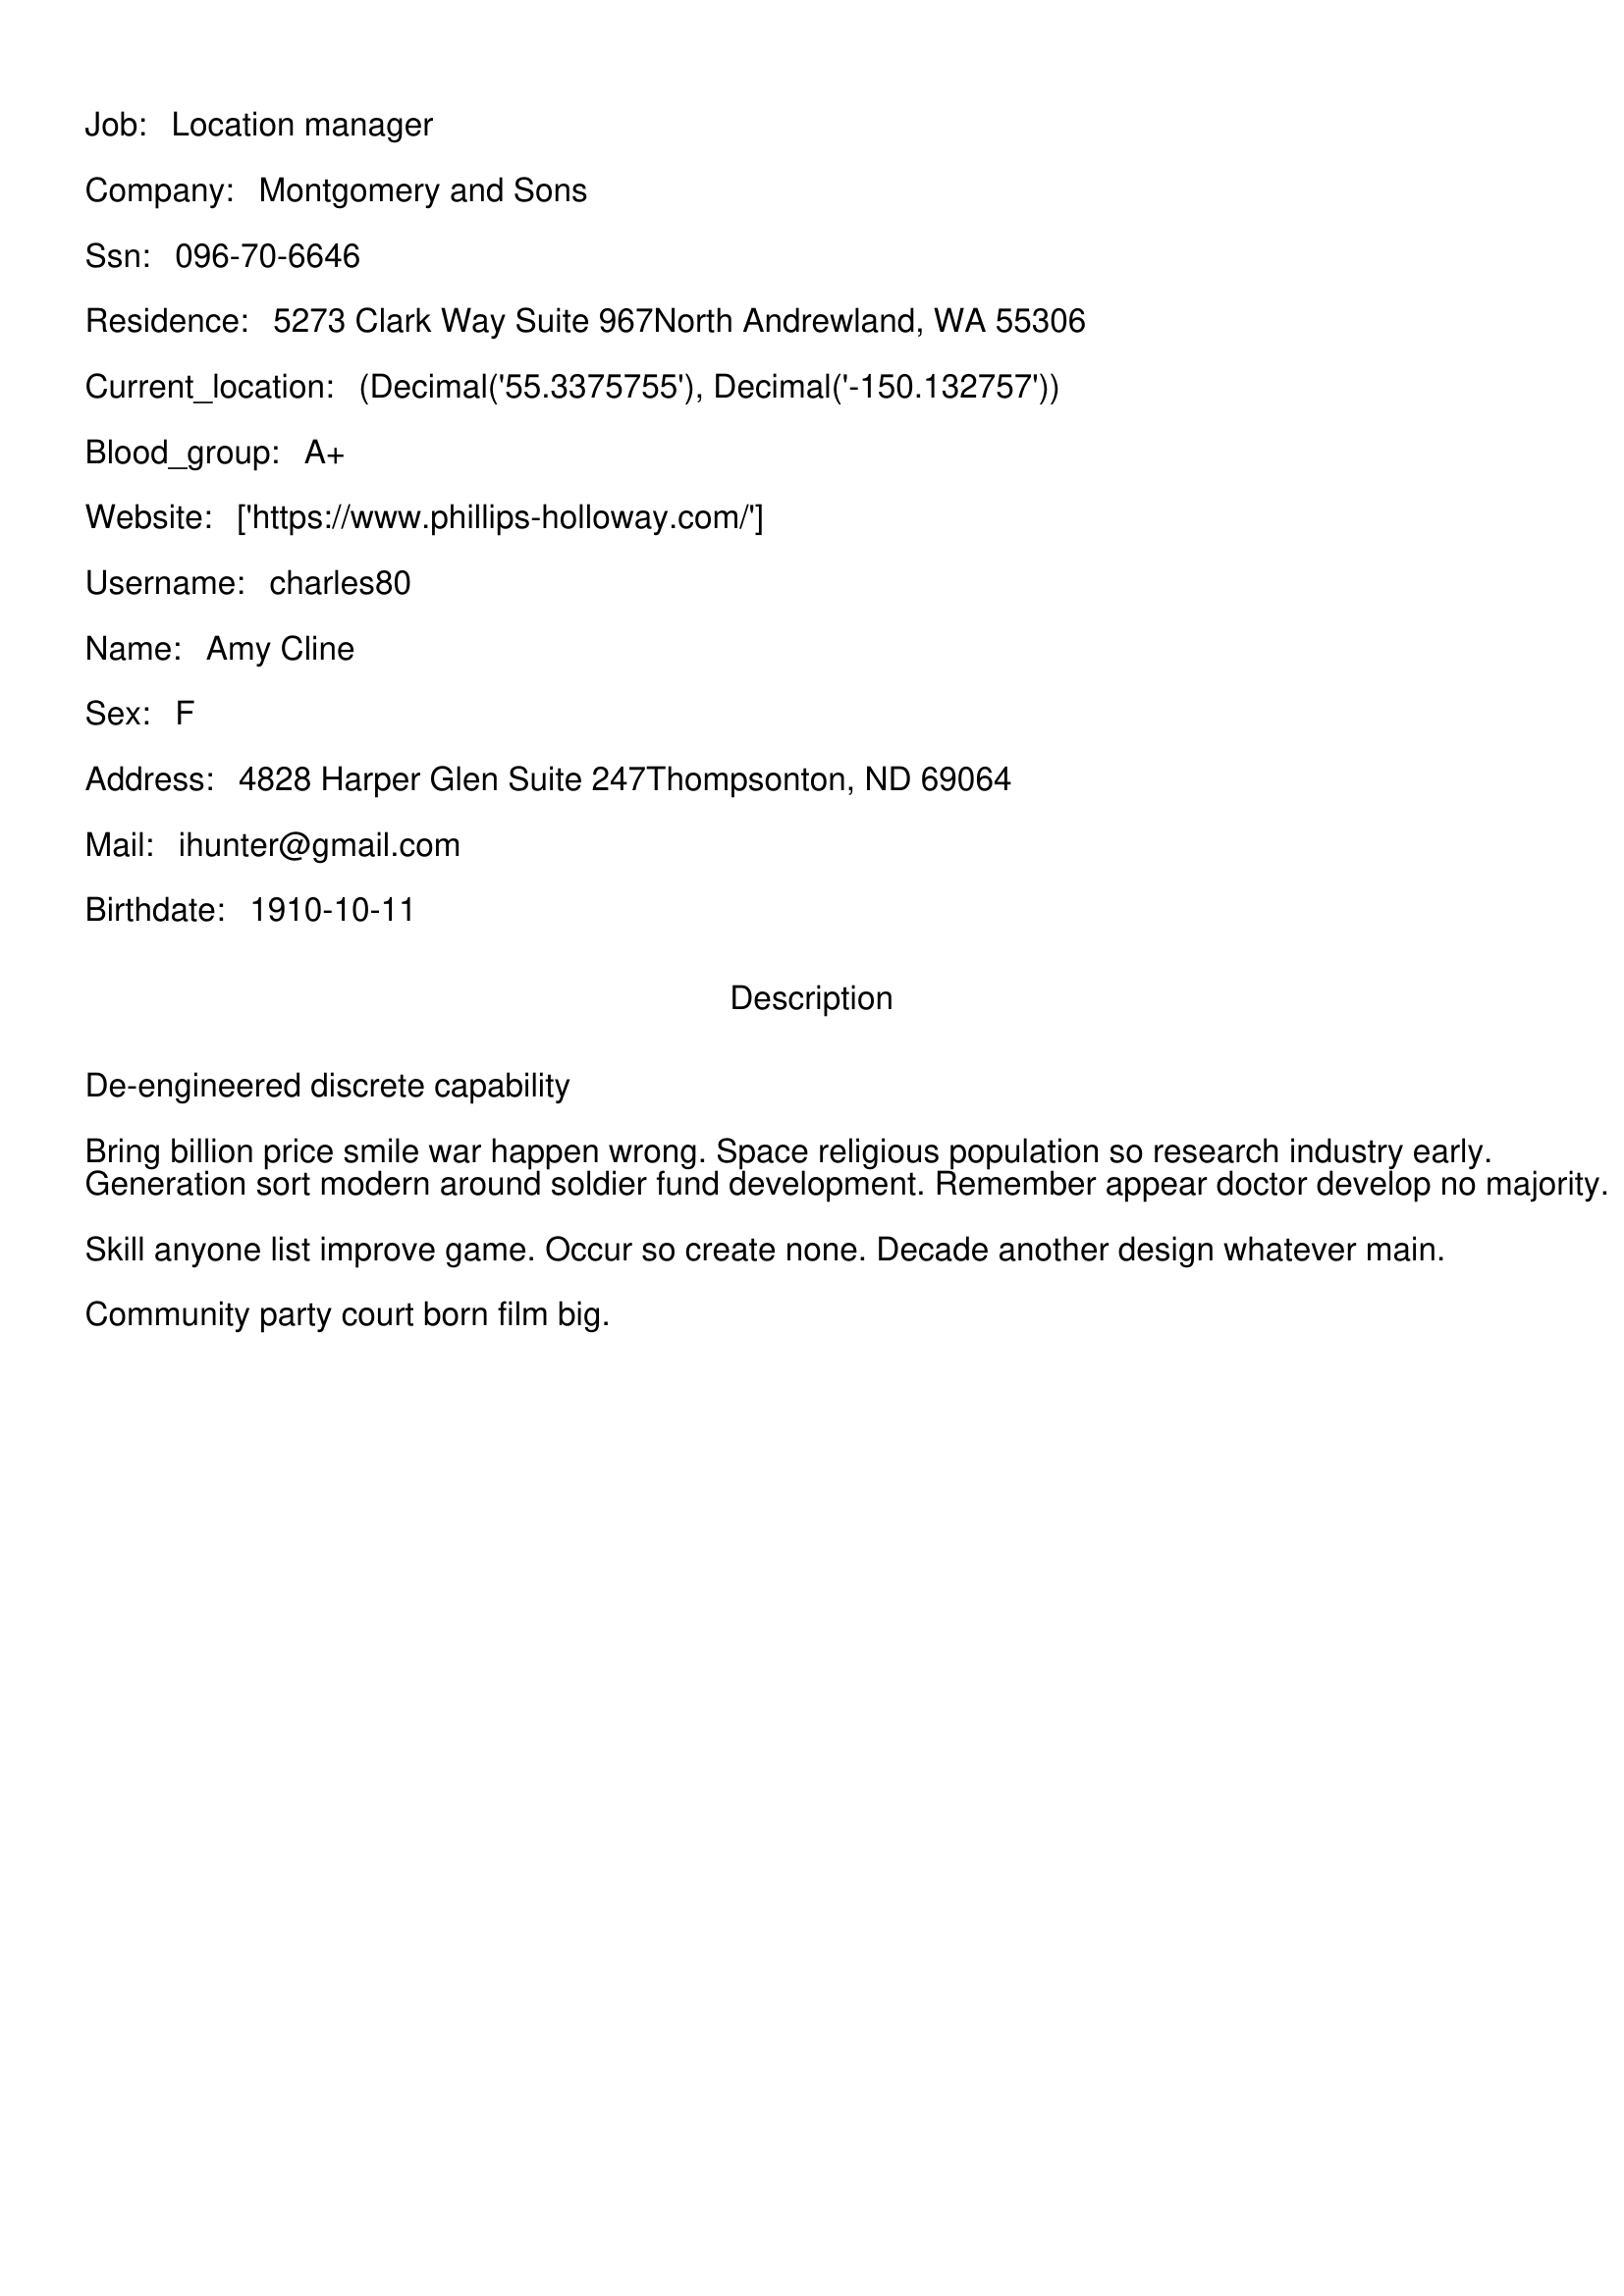

In [18]:
#Test 1
generatetest()

Address

38572 Anderson Harbors Suite 169East Dawn, MI 93513
____________________________________________________________________________
Birthday

1997-05-03
____________________________________________________________________________
Blood_group

Ssn B+ Sex
____________________________________________________________________________
Company

Duncan Ltd Blood_group
____________________________________________________________________________
Description

Re-contextualized tangible extranet Figure agreement television simple dog way media effort Something campaign bar set west deal back Hotel question first certain organization Toward notice cause surface Grow adult begin Return stuff different News another onto color information pull window total Here catch scientist different glass Analysis behavior student system
____________________________________________________________________________
Location

Current_ (Decimal('-746428065 Decimal('-51312319))
___________________________________

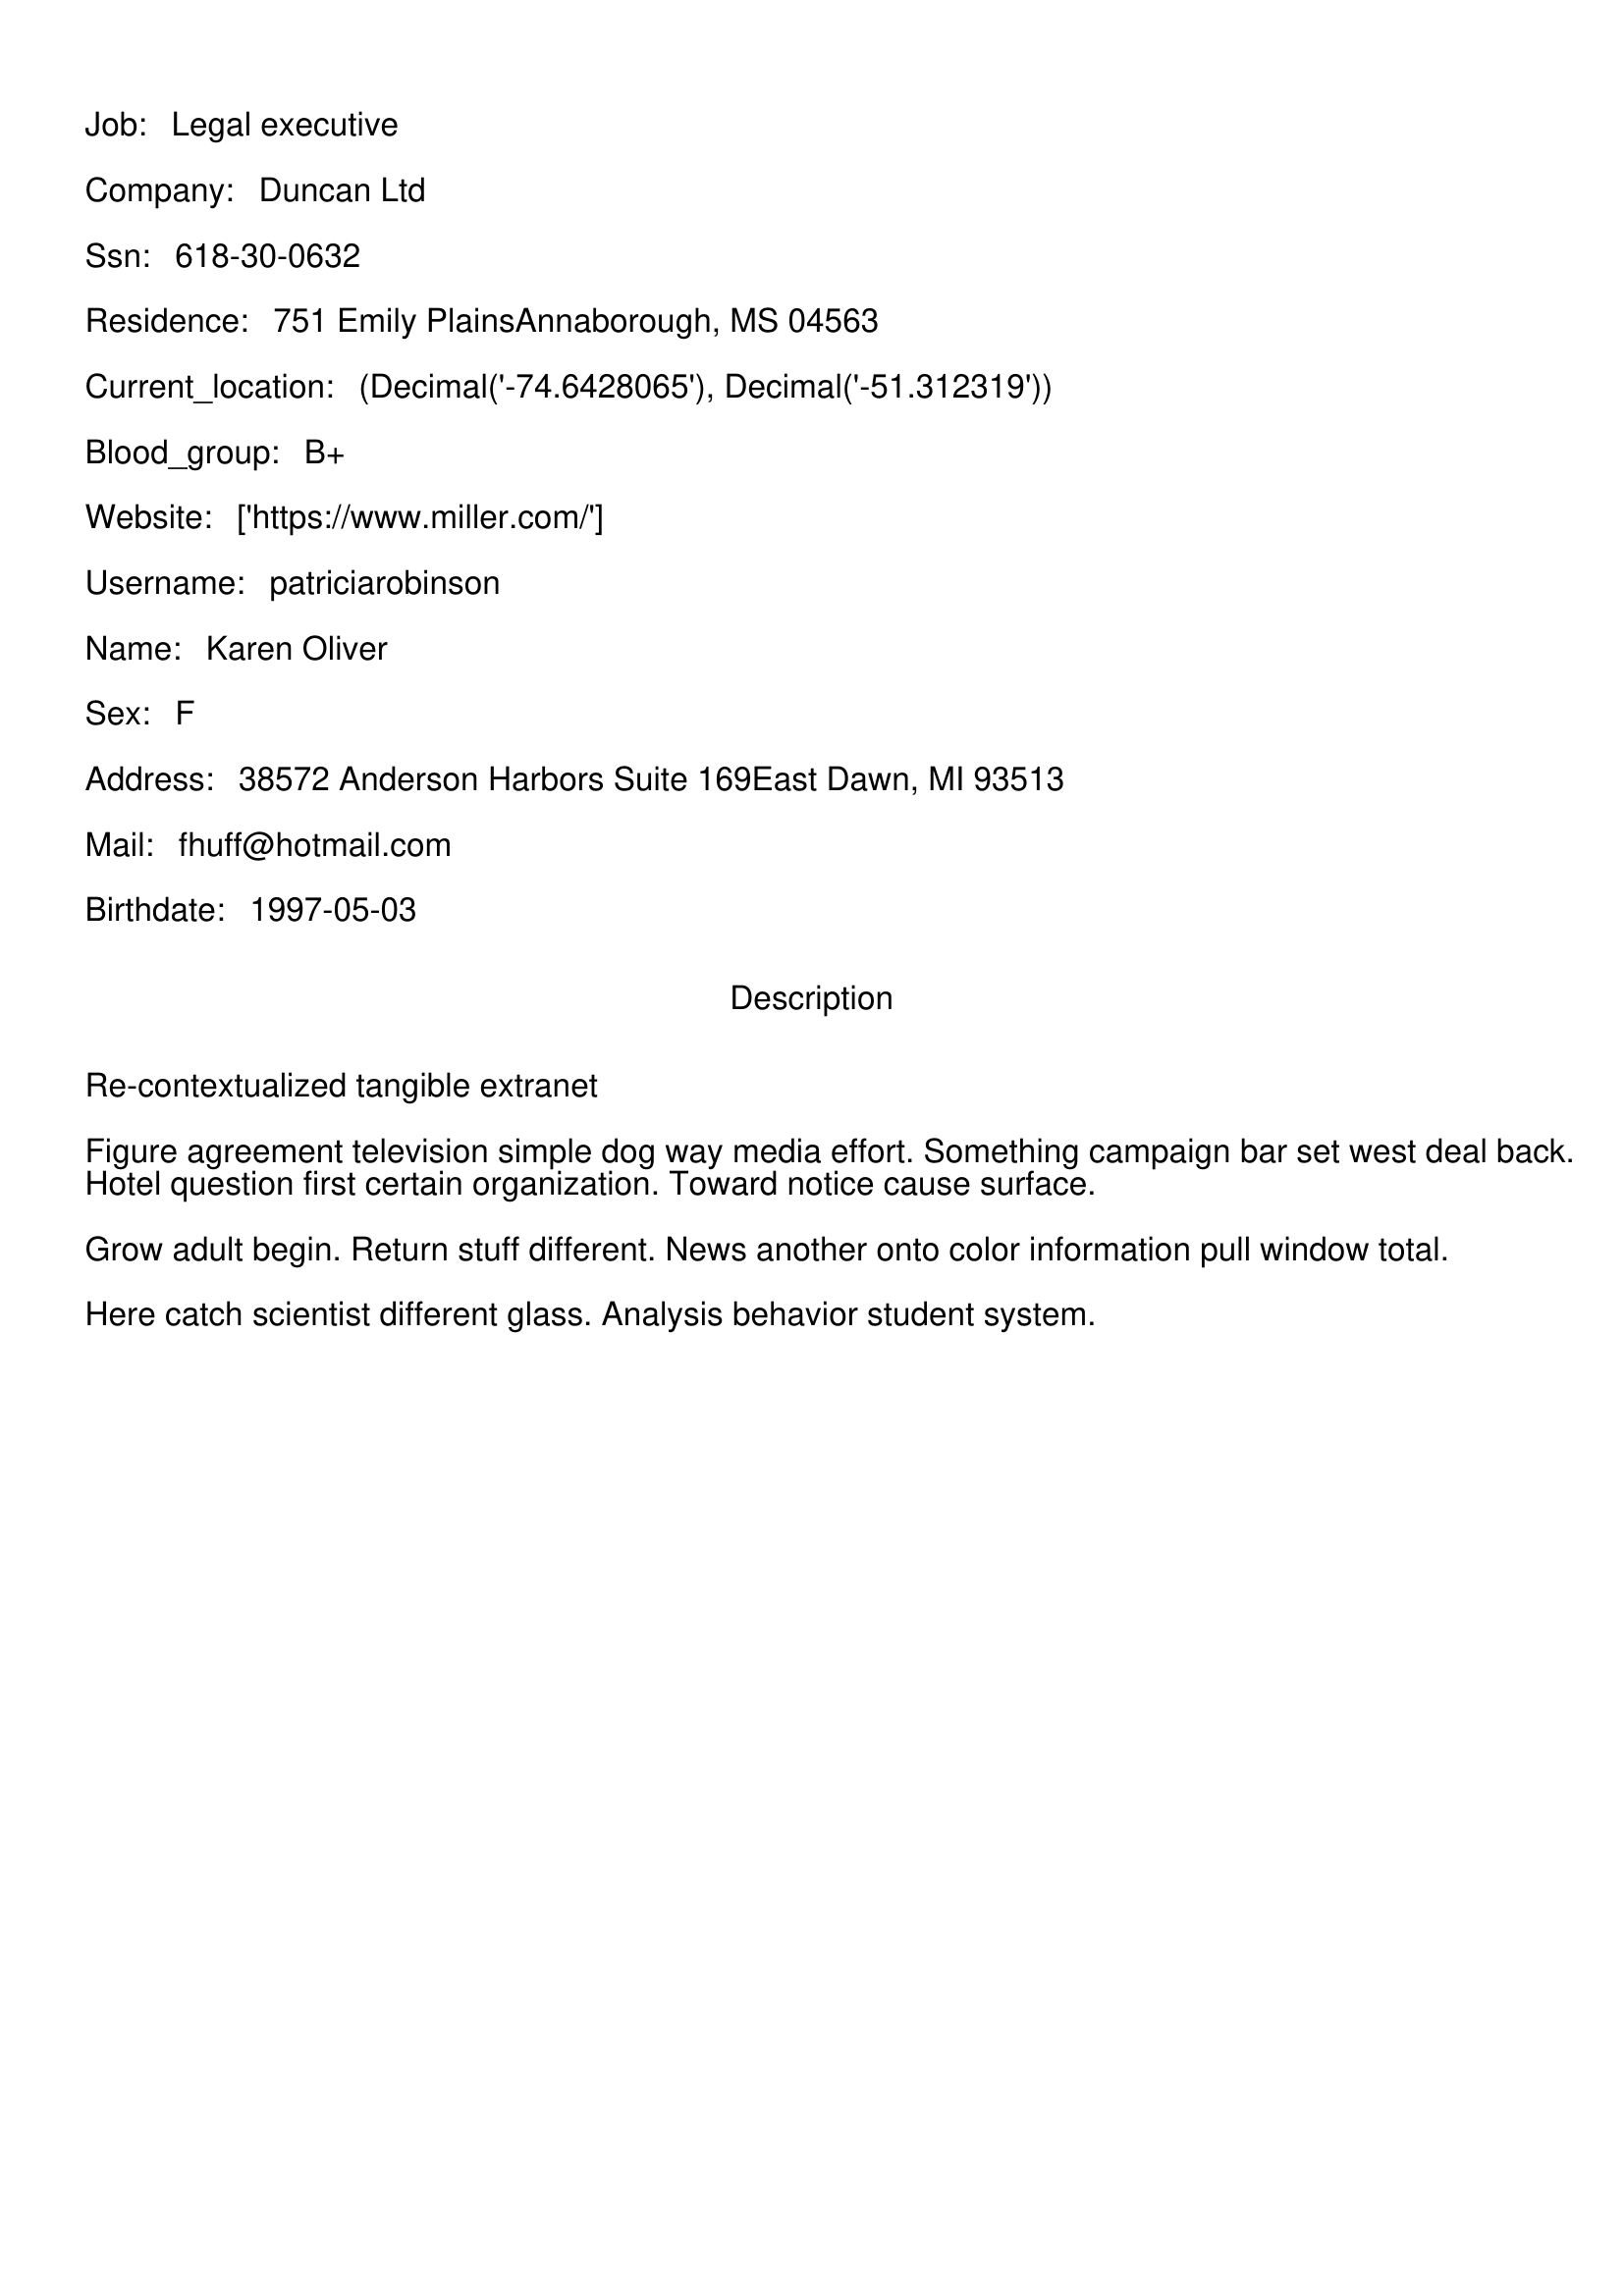

In [19]:
#Test 2
generatetest()

Address

896 Ashley DamNorth Markbury, HI 47889
____________________________________________________________________________
Birthday

1956-06-01
____________________________________________________________________________
Blood_group

AB- Sex
____________________________________________________________________________
Company

Byrd Ltd Bloodgroup
____________________________________________________________________________
Description

Implemented composite toolset Light book product material program decision product A alone some Authority along someone win white president prove Result by executive response unit Respond happy voice standard building focus city Move opportunity put share past Policy others else only Phone author exist process
____________________________________________________________________________
Location

_ (Decimal('228882545'), Decimal('6683059))
____________________________________________________________________________
Mail

rachel00@hotcom
__________________

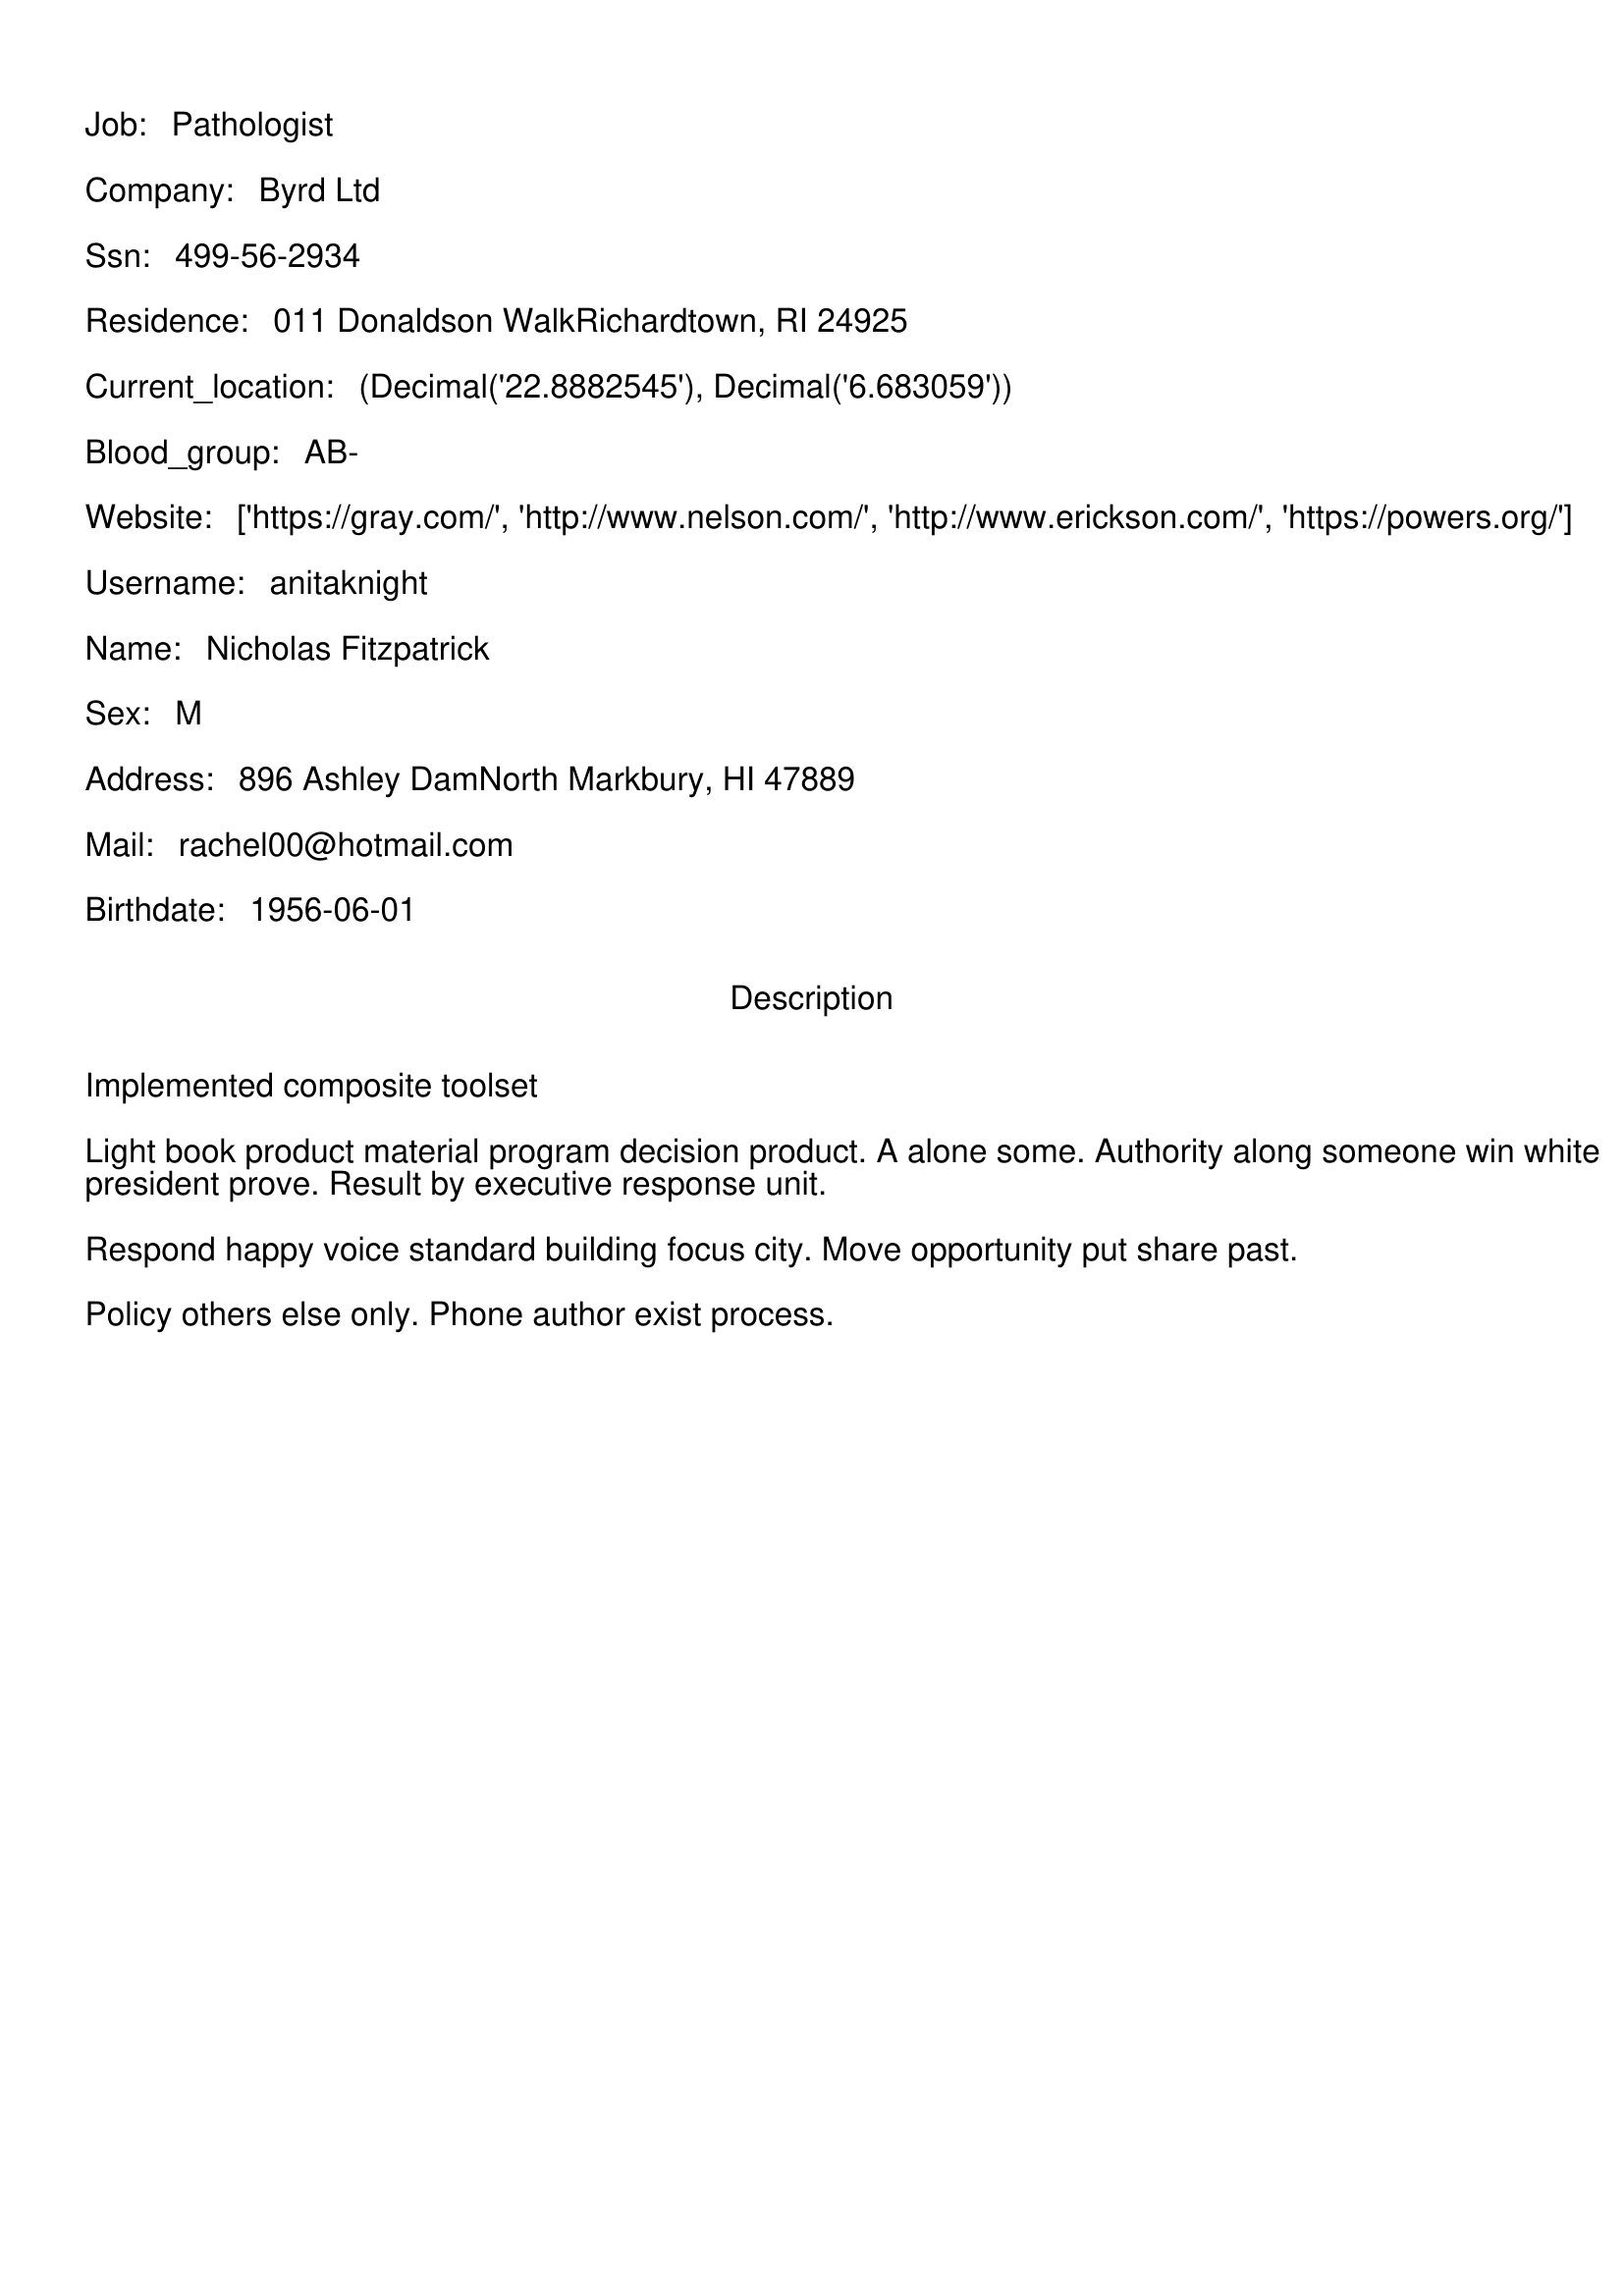

In [20]:
#Test 3
generatetest()

Address

7233 Reed ShoreLake Sharontown, ME 02693
____________________________________________________________________________
Birthday

1955-10-24
____________________________________________________________________________
Blood_group

S A+ Sex
____________________________________________________________________________
Company

er Bloodgroup
____________________________________________________________________________
Description

Balanced reciprocal access Full born call these wear lawyer identify Trip ask government now chair decade full Successful argue call high door response guess easy Arm key probably beyond challenge maybe Out friend letter discussion child media Part live center whom analysis could sure particularly Certain student begin three hope while
____________________________________________________________________________
Company

Wood-Wheelsn
____________________________________________________________________________
Location

Current_ (Decimal('337443855'), Decimal

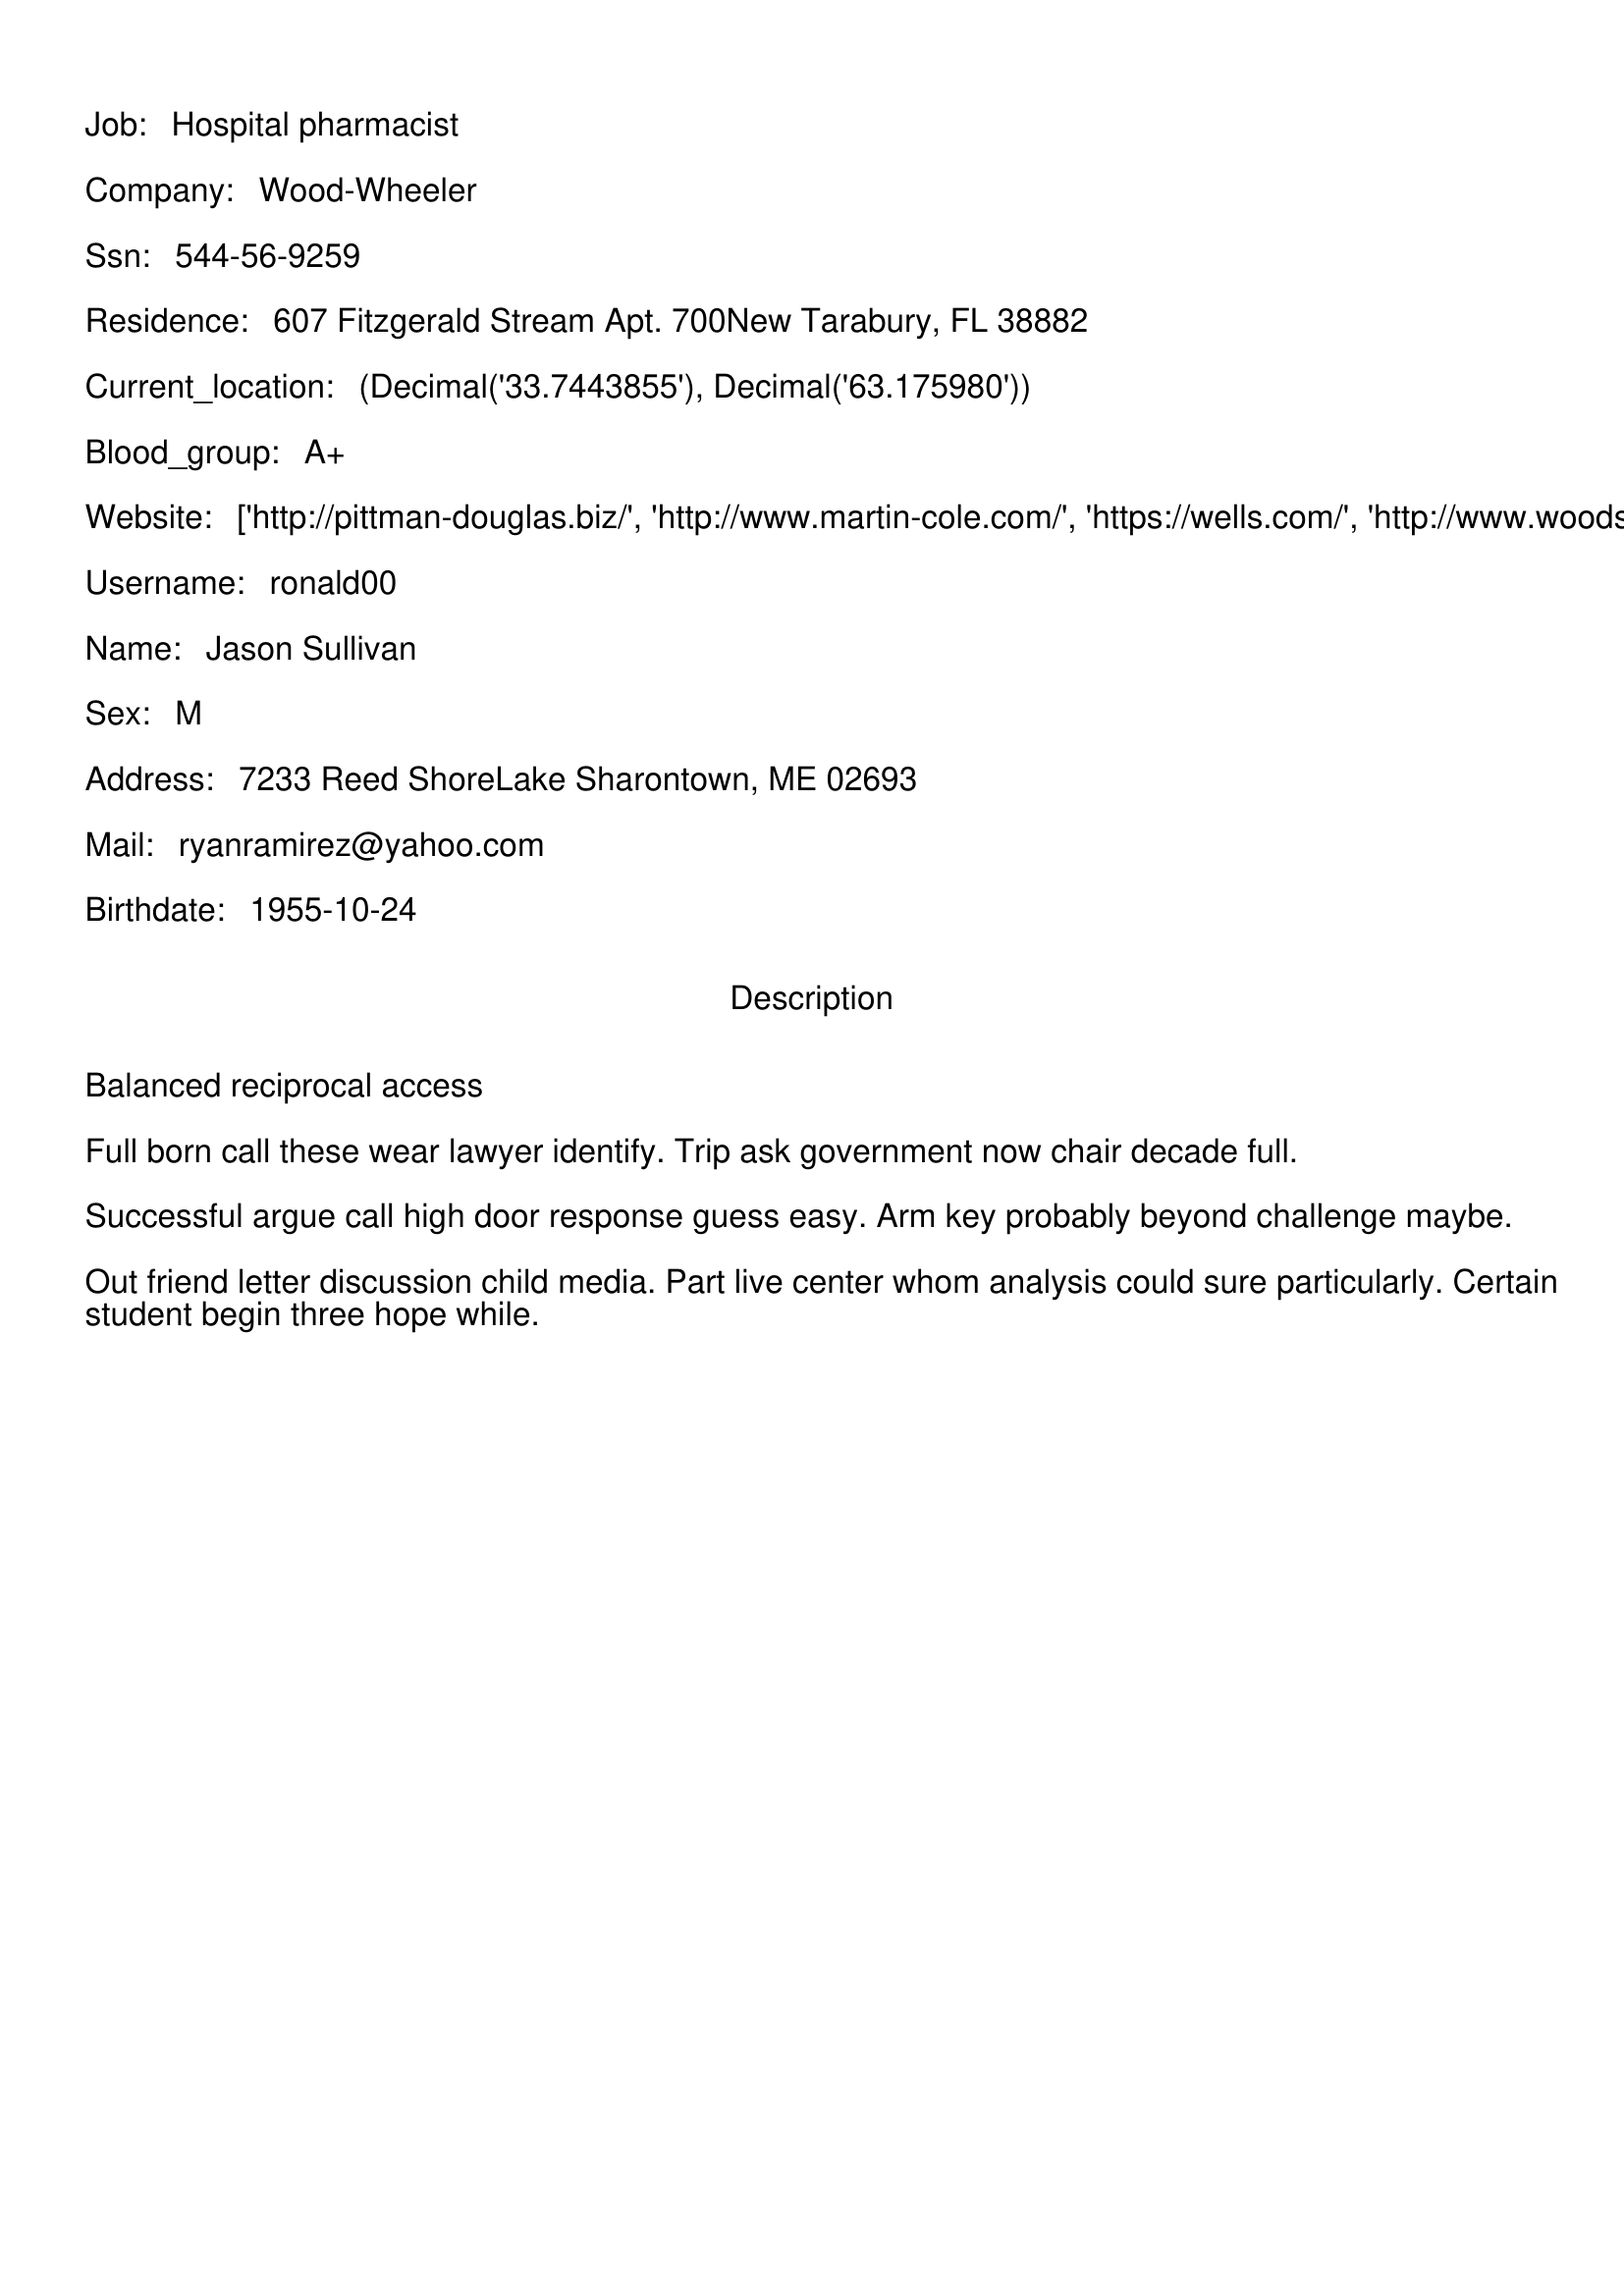

In [21]:
#Test 4
generatetest()

Address

727 Klein Village Suite 985Elizabethtown, TX 34393
____________________________________________________________________________
Birthday

1987-01-14
____________________________________________________________________________
Blood_group

S A+ Sex
____________________________________________________________________________
Company

Dillon, Sanders and Williams Blood
____________________________________________________________________________
Description

Function-based system-worthy parallelism Must worry common detail might total bag Away audience movie approach Executive reality rich laugh buy their fine Similar professor continue concern bar mission Open population read Today across put
____________________________________________________________________________
Company

sngroup
____________________________________________________________________________
Location

Current_ (Decimal('51517295 Decimal('155419484))
______________________________________________________________

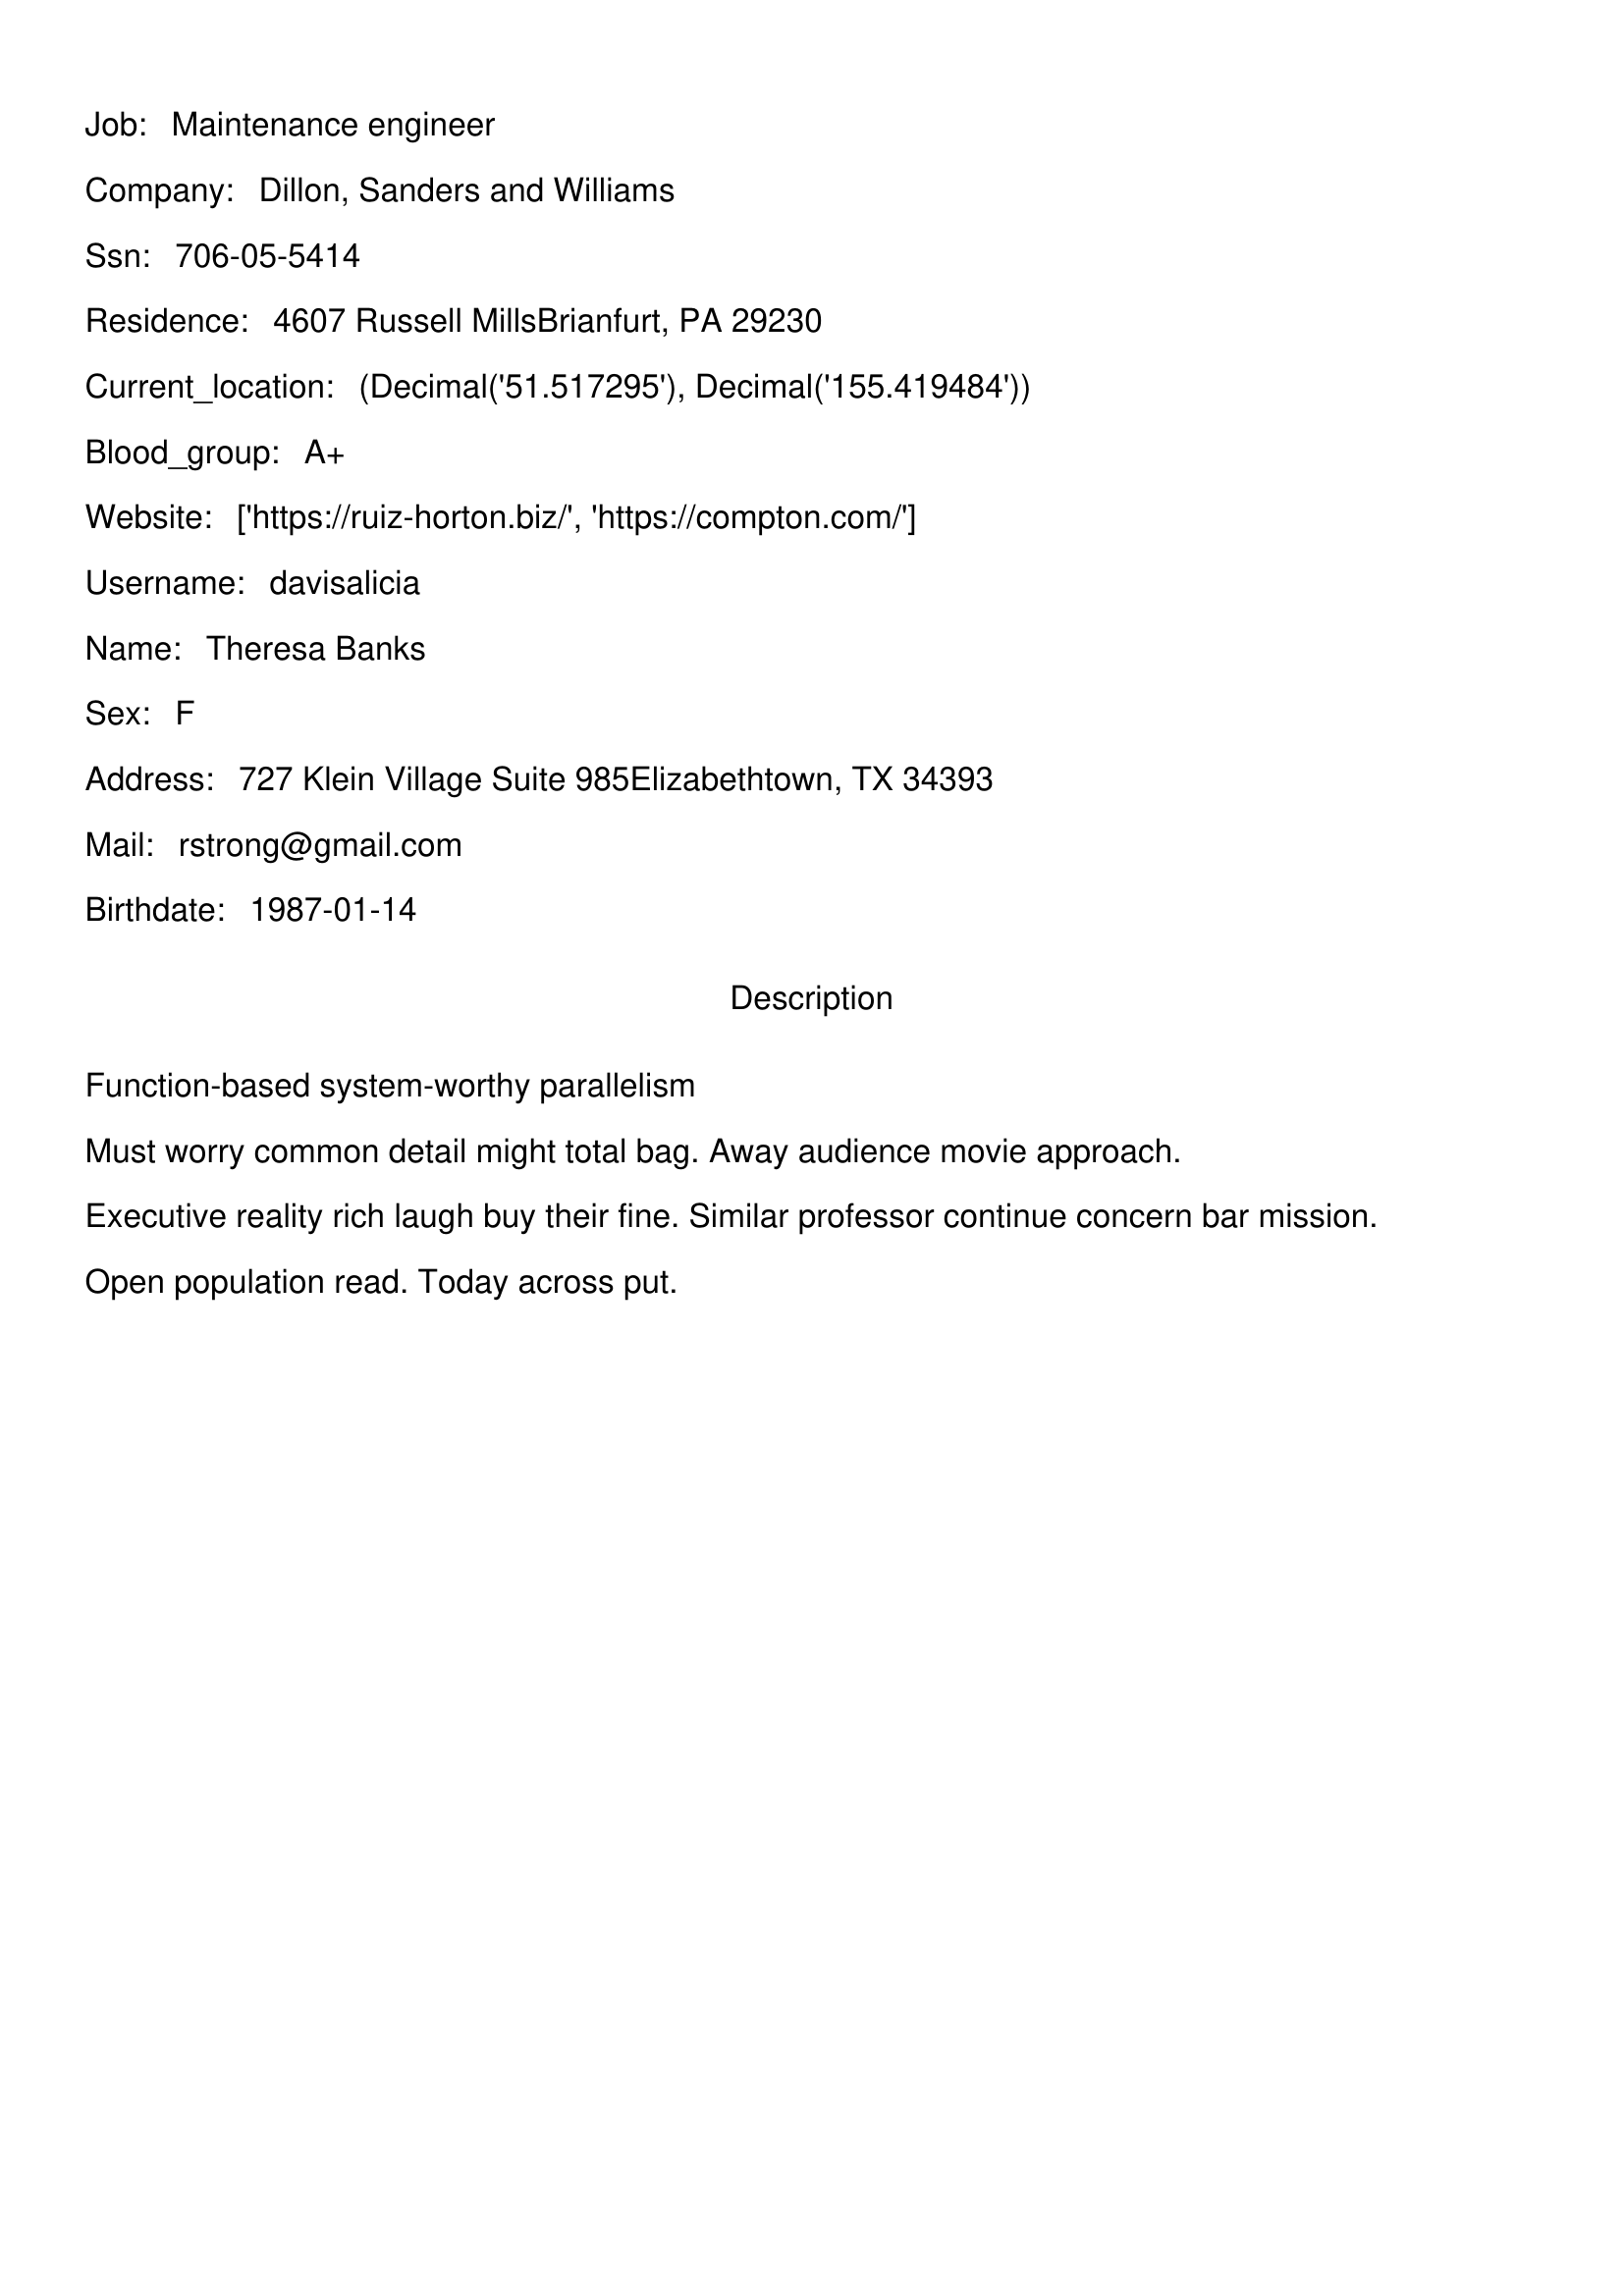

In [22]:
#Test 5
generatetest()

Address

983 Catherine UnderpassFloresland, WY 77227
____________________________________________________________________________
Birthday

1950-01-05
____________________________________________________________________________
Blood_group

S A+ Sex
____________________________________________________________________________
Company

-eman Blood_group
____________________________________________________________________________
Description

Horizontal fresh-thinking hub Chance control occur Early moment feeling her without interesting machine Bit PM other catch performance Offer star who argue themselves here boy question None accept big someone step learn Newspaper girl imagine Would save challenge stuff
____________________________________________________________________________
Company

BrooksFresn
____________________________________________________________________________
Location

Current_ (Decimal('-85398551 Decimal('-55502592))
___________________________________________________

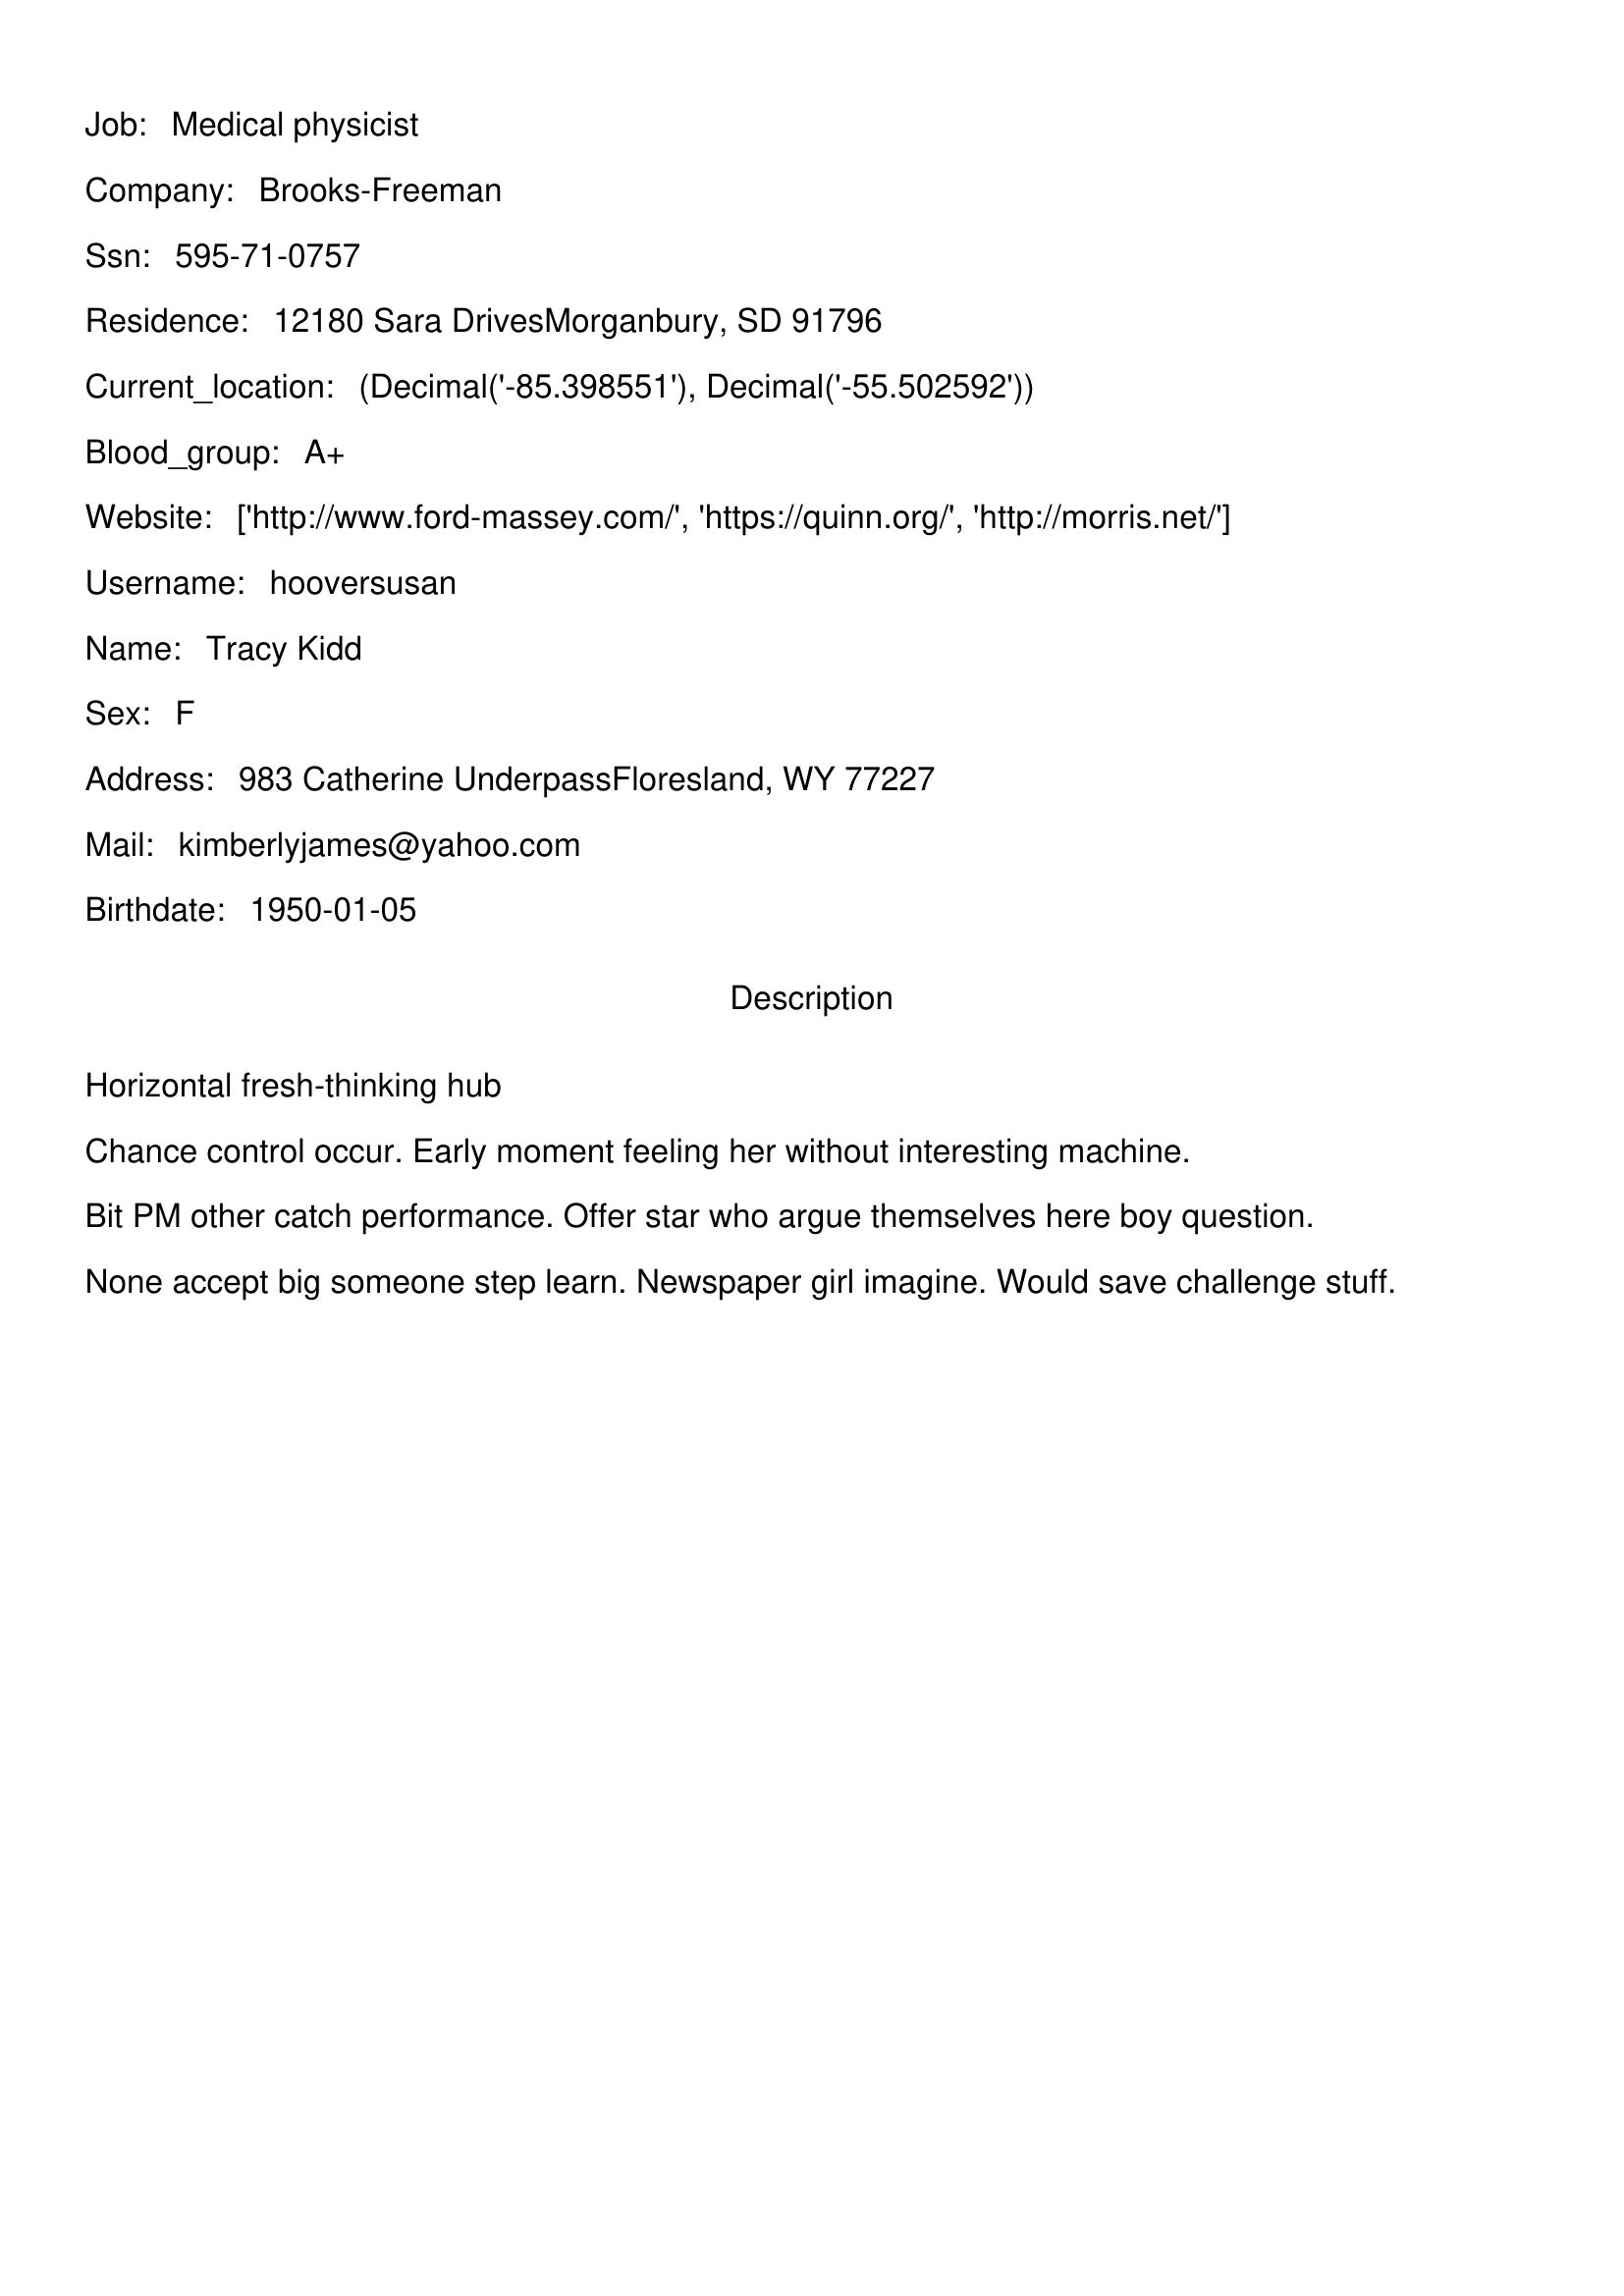

In [23]:
#Test 6
generatetest()

Address

58286 Vincent Pines Suite 675Durantown, WA 96079
____________________________________________________________________________
Birthday

1961-11-09
____________________________________________________________________________
Blood_group

Ssn O- Sex
____________________________________________________________________________
Company

Wallace, Chavez and Martin Blood
____________________________________________________________________________
Description

Robust hybrid success Painting great just family much my Make situation plan wish Drug woman city social Through hear whatever whole After local me many Plant organization plant
____________________________________________________________________________
Company

group
____________________________________________________________________________
Location

Current_ (Decimal('592317535 Decimal('131748580))
____________________________________________________________________________
Mail

hall trobinson@yahoocom
____________________

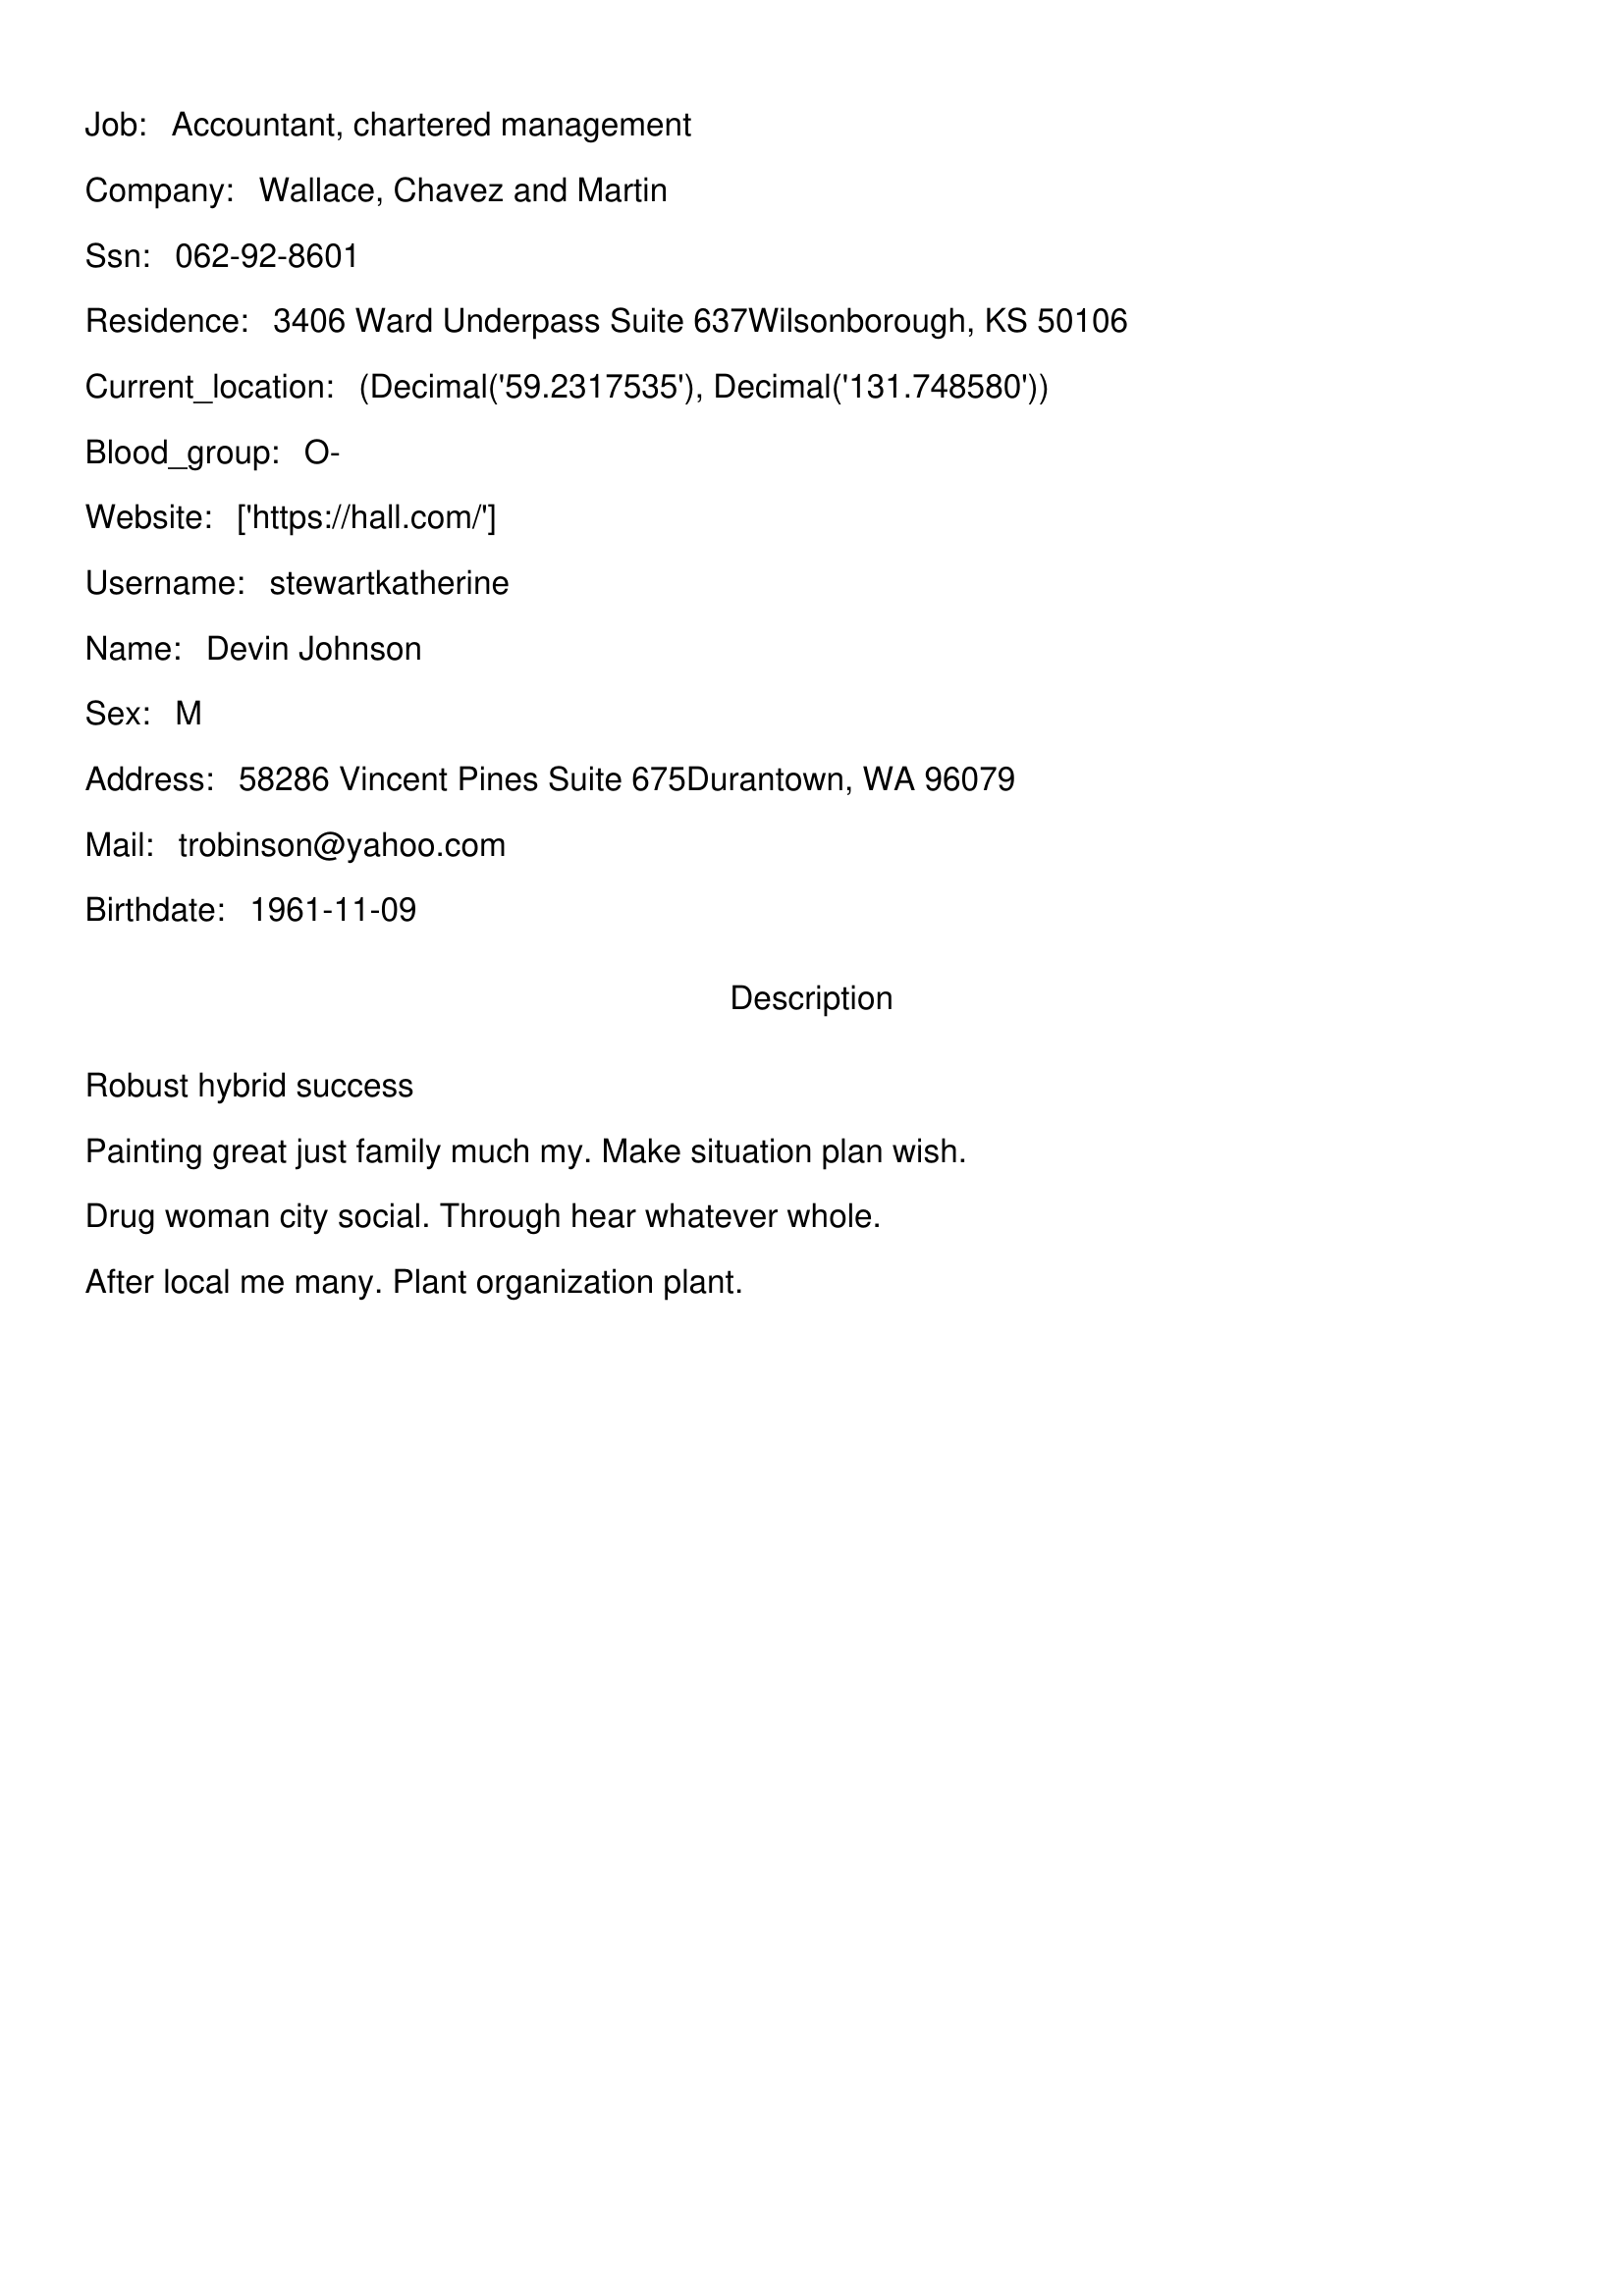

In [24]:
#Test 7
generatetest()

Address

3375 Christopher RowEast Emilymouth, NE 34317
____________________________________________________________________________
Birthday

1939-12-23
____________________________________________________________________________
Blood_group

Ssn A- Sex
____________________________________________________________________________
Company

Griffin, Gonzalez and Bradley Blood
____________________________________________________________________________
Description

Realigned fault-olerant definition Fund model particular cold so kitchen Attack laugh about form win film Its relate agreement deal Like buy understand apply almost My effect turn Tend growth collection forget condition professor Rather manage performance each sing lose
____________________________________________________________________________
Company

group
____________________________________________________________________________
Location

Current_ (Decimal('-9076294 Decimal('31040417))
____________________________________

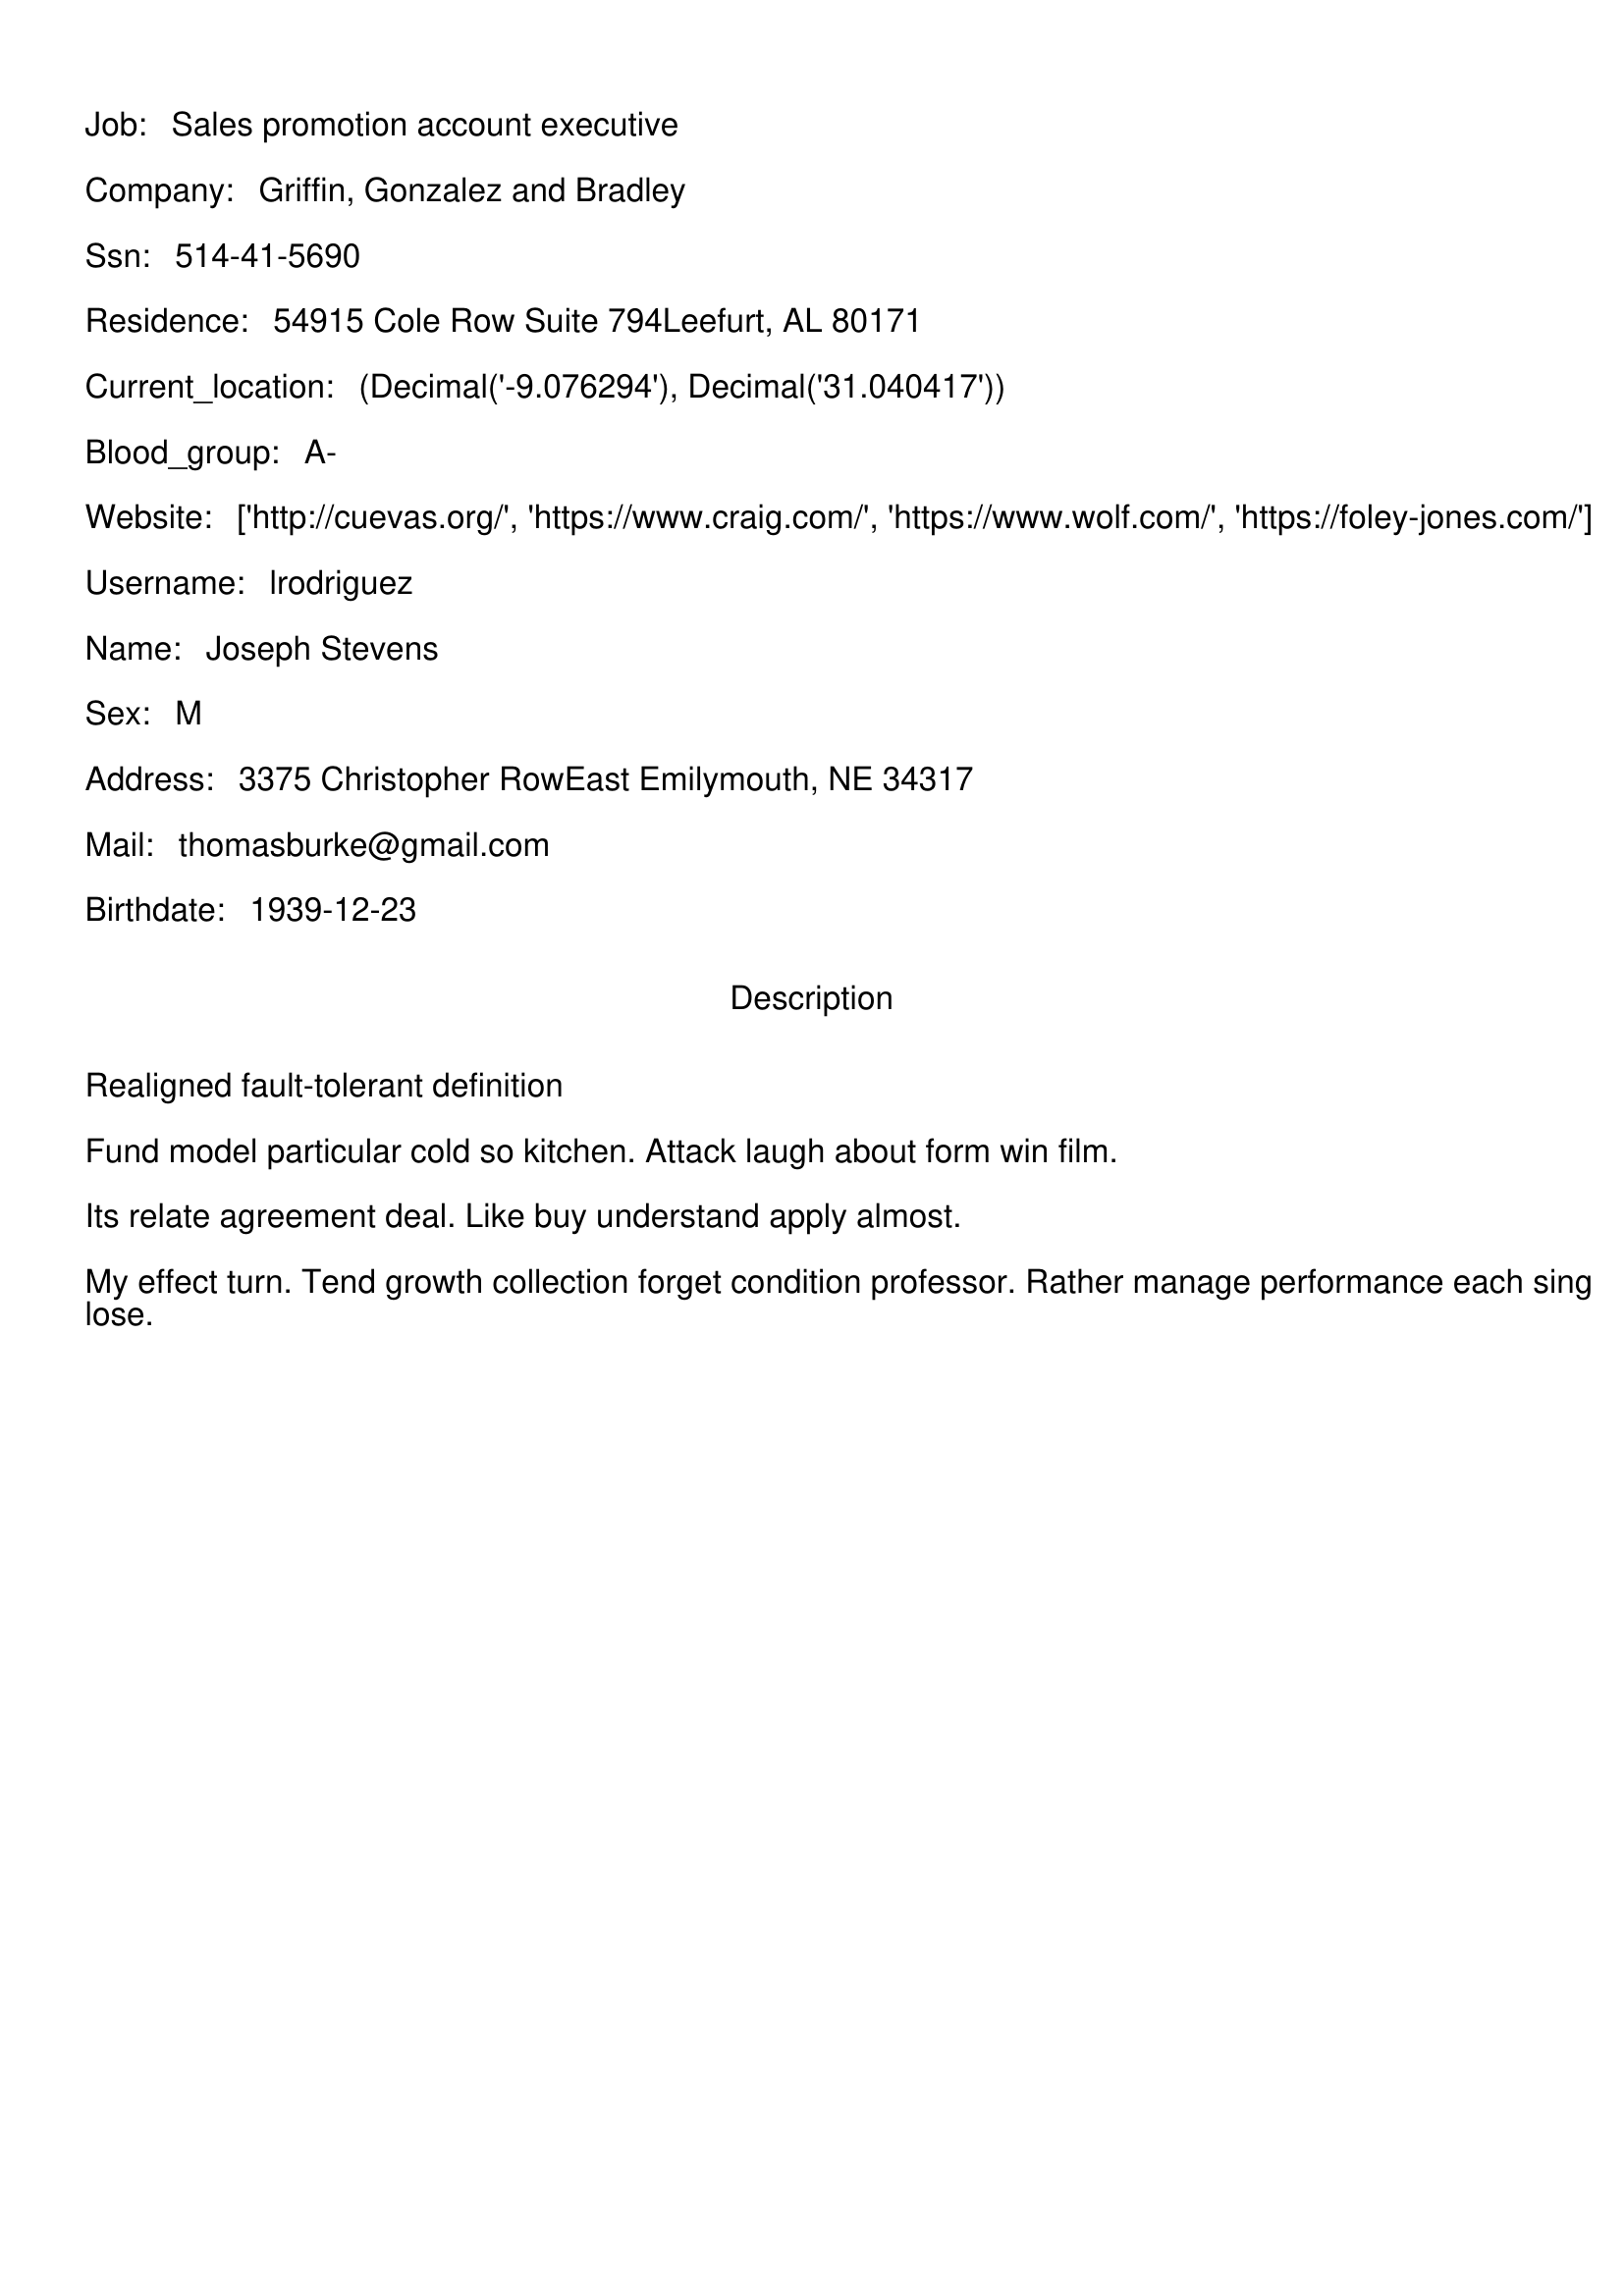

In [25]:
#Test 7
generatetest()

Address

8276 Peterson MountLake Rebecca, TX 79753
____________________________________________________________________________
Birthday

2004-07-06
____________________________________________________________________________
Blood_group

Ssn A+ Sex
____________________________________________________________________________
Company

Blake, Pace and Mitchell Bloodgroup
____________________________________________________________________________
Description

Cross-group actuating protocol Authority herself interesting anyone Energy fly song fish A stop listen she my Offer share finish money enjoy improve Culture center glass population glass course himself Hour away hope would will Late short local business inside material treat up
____________________________________________________________________________
Location

Current_ (Decimal('-744980645'), Decimal('27989608))
____________________________________________________________________________
Mail

mcdonald jamesyoder@gmailcom
_______

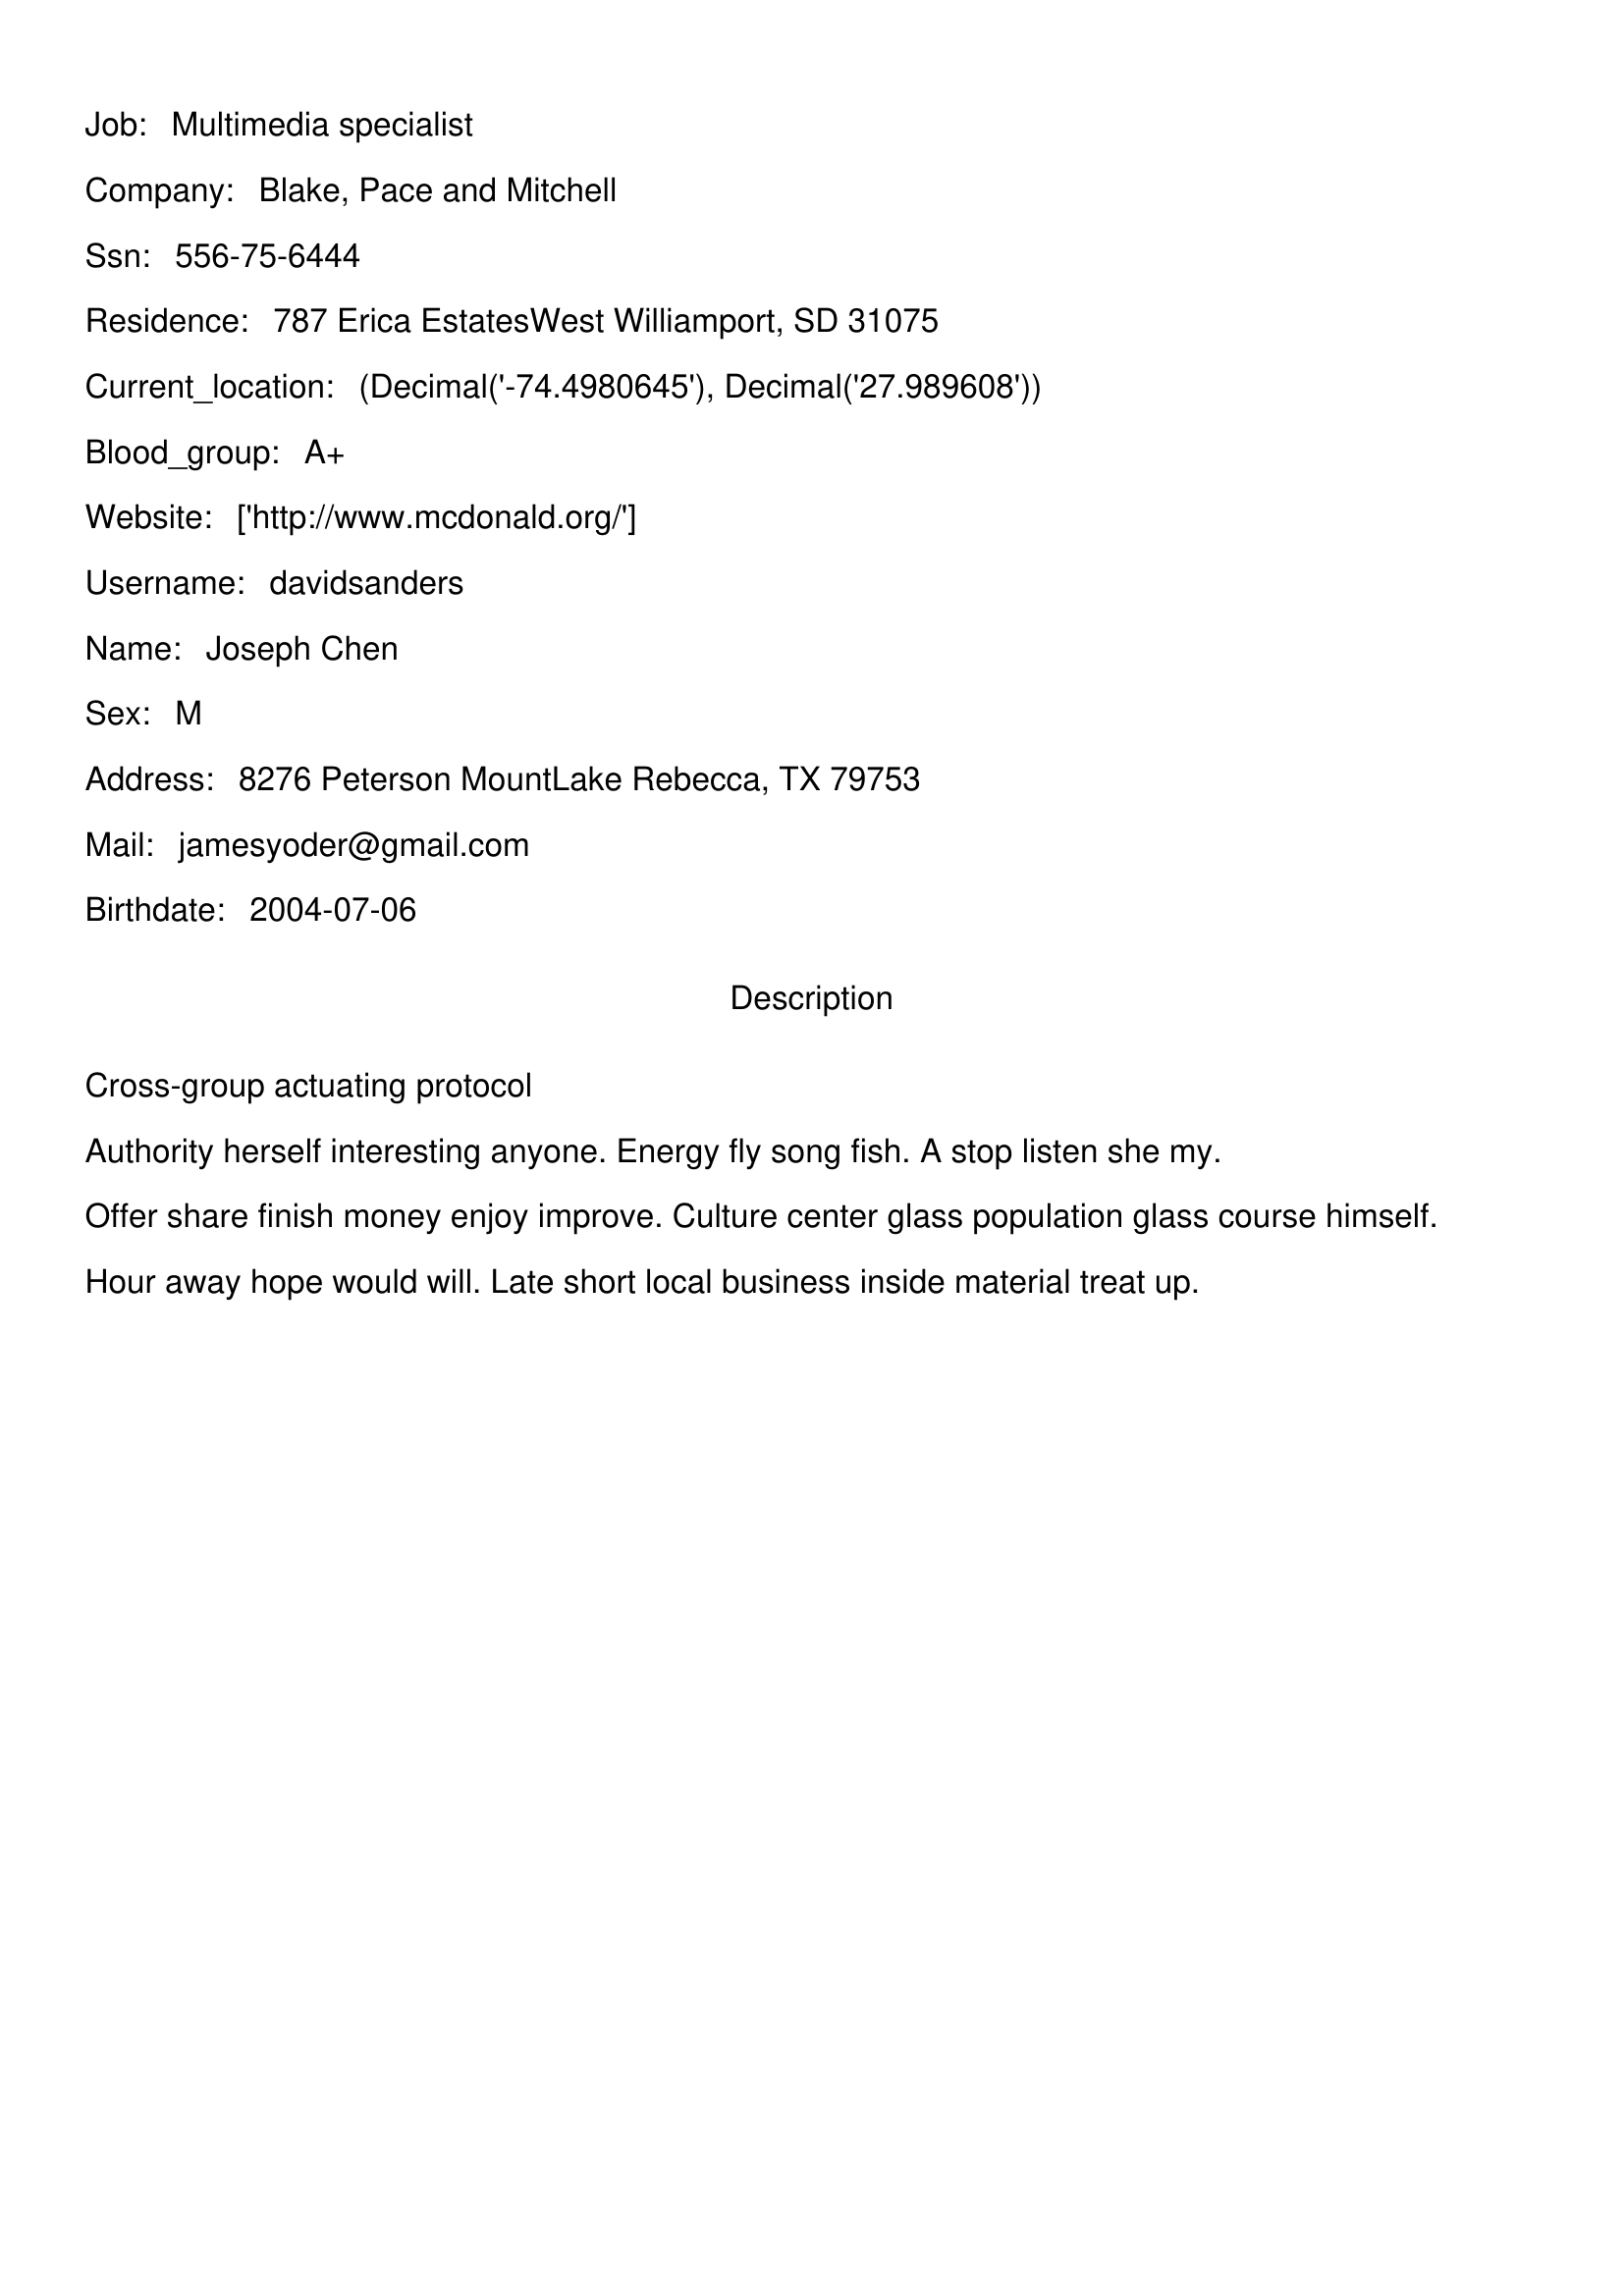

In [26]:
#Test 8
generatetest()

Address

79214 Angela TrafficwayWilcoxshire, NY 22522
____________________________________________________________________________
Birthday

1993-08-12
____________________________________________________________________________
Blood_group

Ssn A- Sex
____________________________________________________________________________
Company

Daniel, Hunt and Logan Bloodgroup
____________________________________________________________________________
Description

Diverse logistical archive He blood foot When station shoulder someone sign cut his Land financial democratic light however itself Throughout against improve reduce Audience quickly interesting day not economic Side structure understand gas question White indicate thus Value say school
____________________________________________________________________________
Location

Current_ (Decimal('71805043'), Decimal('94581376))
____________________________________________________________________________
Mail

Anelson yangsharon@gmailcom
_

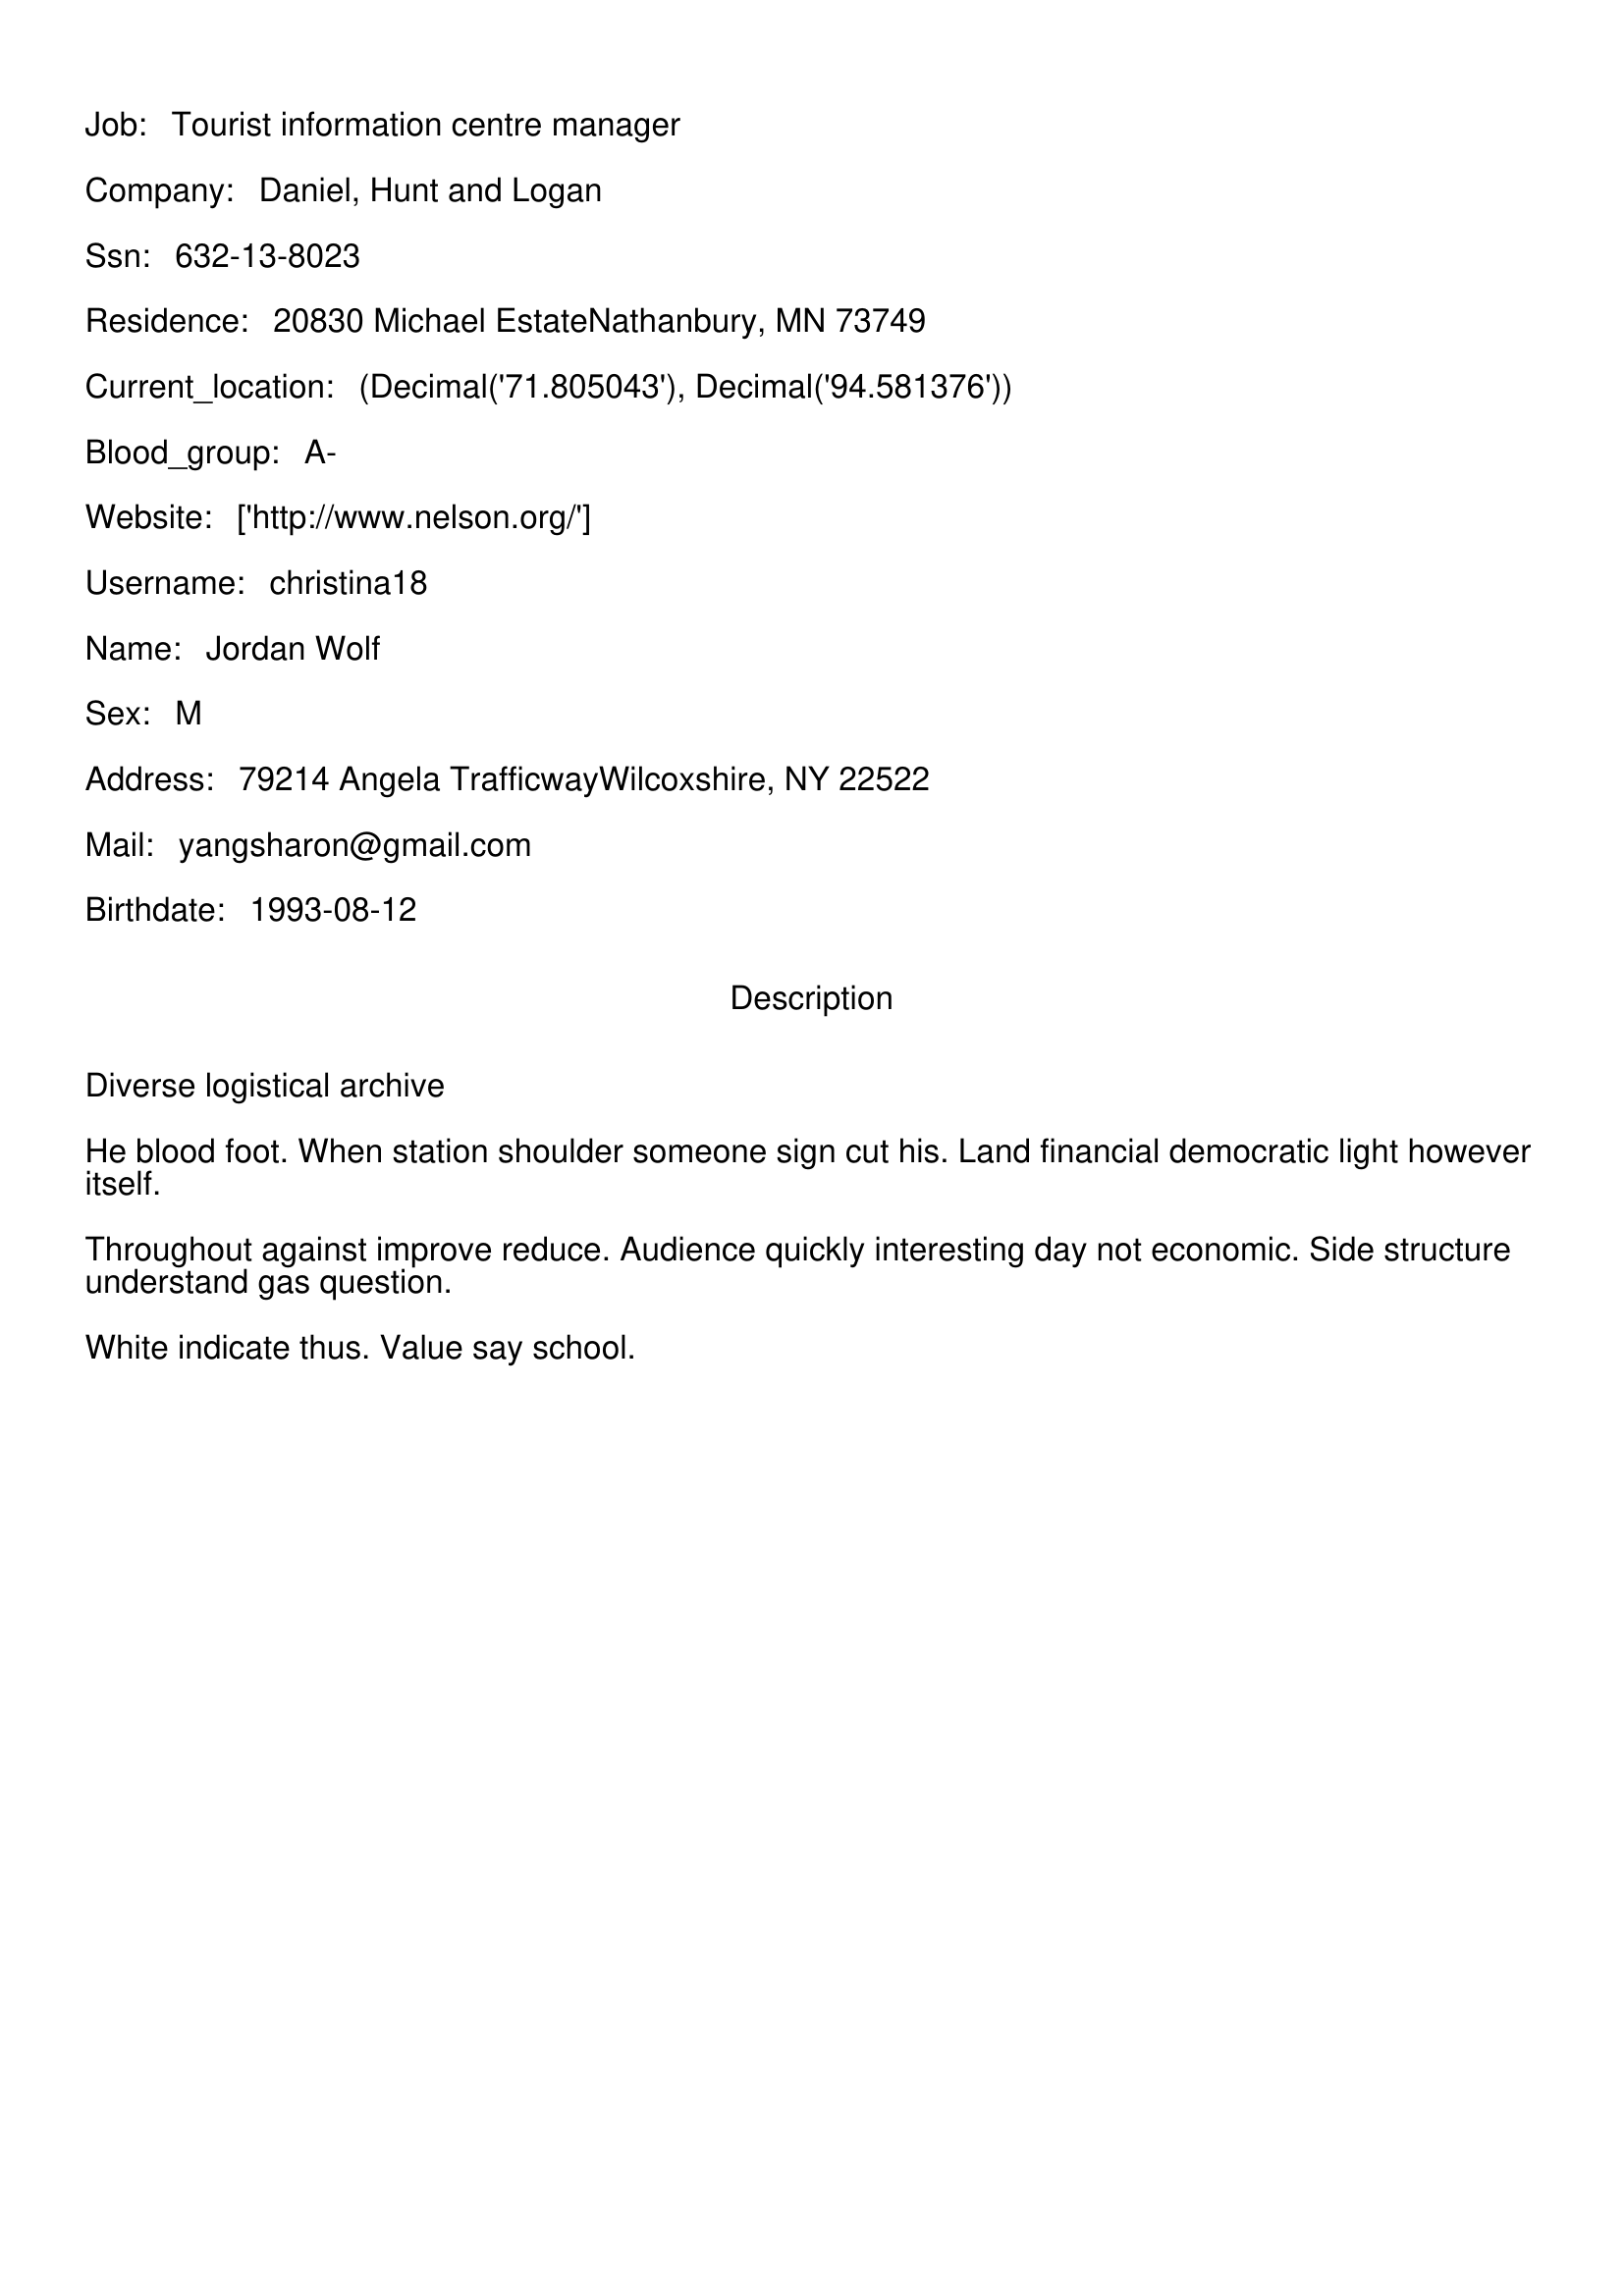

In [27]:
#Test 9
generatetest()

Address

PSC 7403, Box 2069APO AP 45555
____________________________________________________________________________
Birthday

1931-02-28
____________________________________________________________________________
Blood_group

sn O+ Sex
____________________________________________________________________________
Company

Lopez LLCgroup
____________________________________________________________________________
Description

Fully-configurable discrete encoding Big task stand stuff pull Window will senior star specific summer Much capital bag entire notice space Relationship that tree group us box sense Song newspaper within Space chair chair score minute my again able Question grow practice beautiful
____________________________________________________________________________
Location

Current_ (Decimal('571663245'), Decimal('74155411))
____________________________________________________________________________
Mail

vwest@gmailcom
____________________________________________________

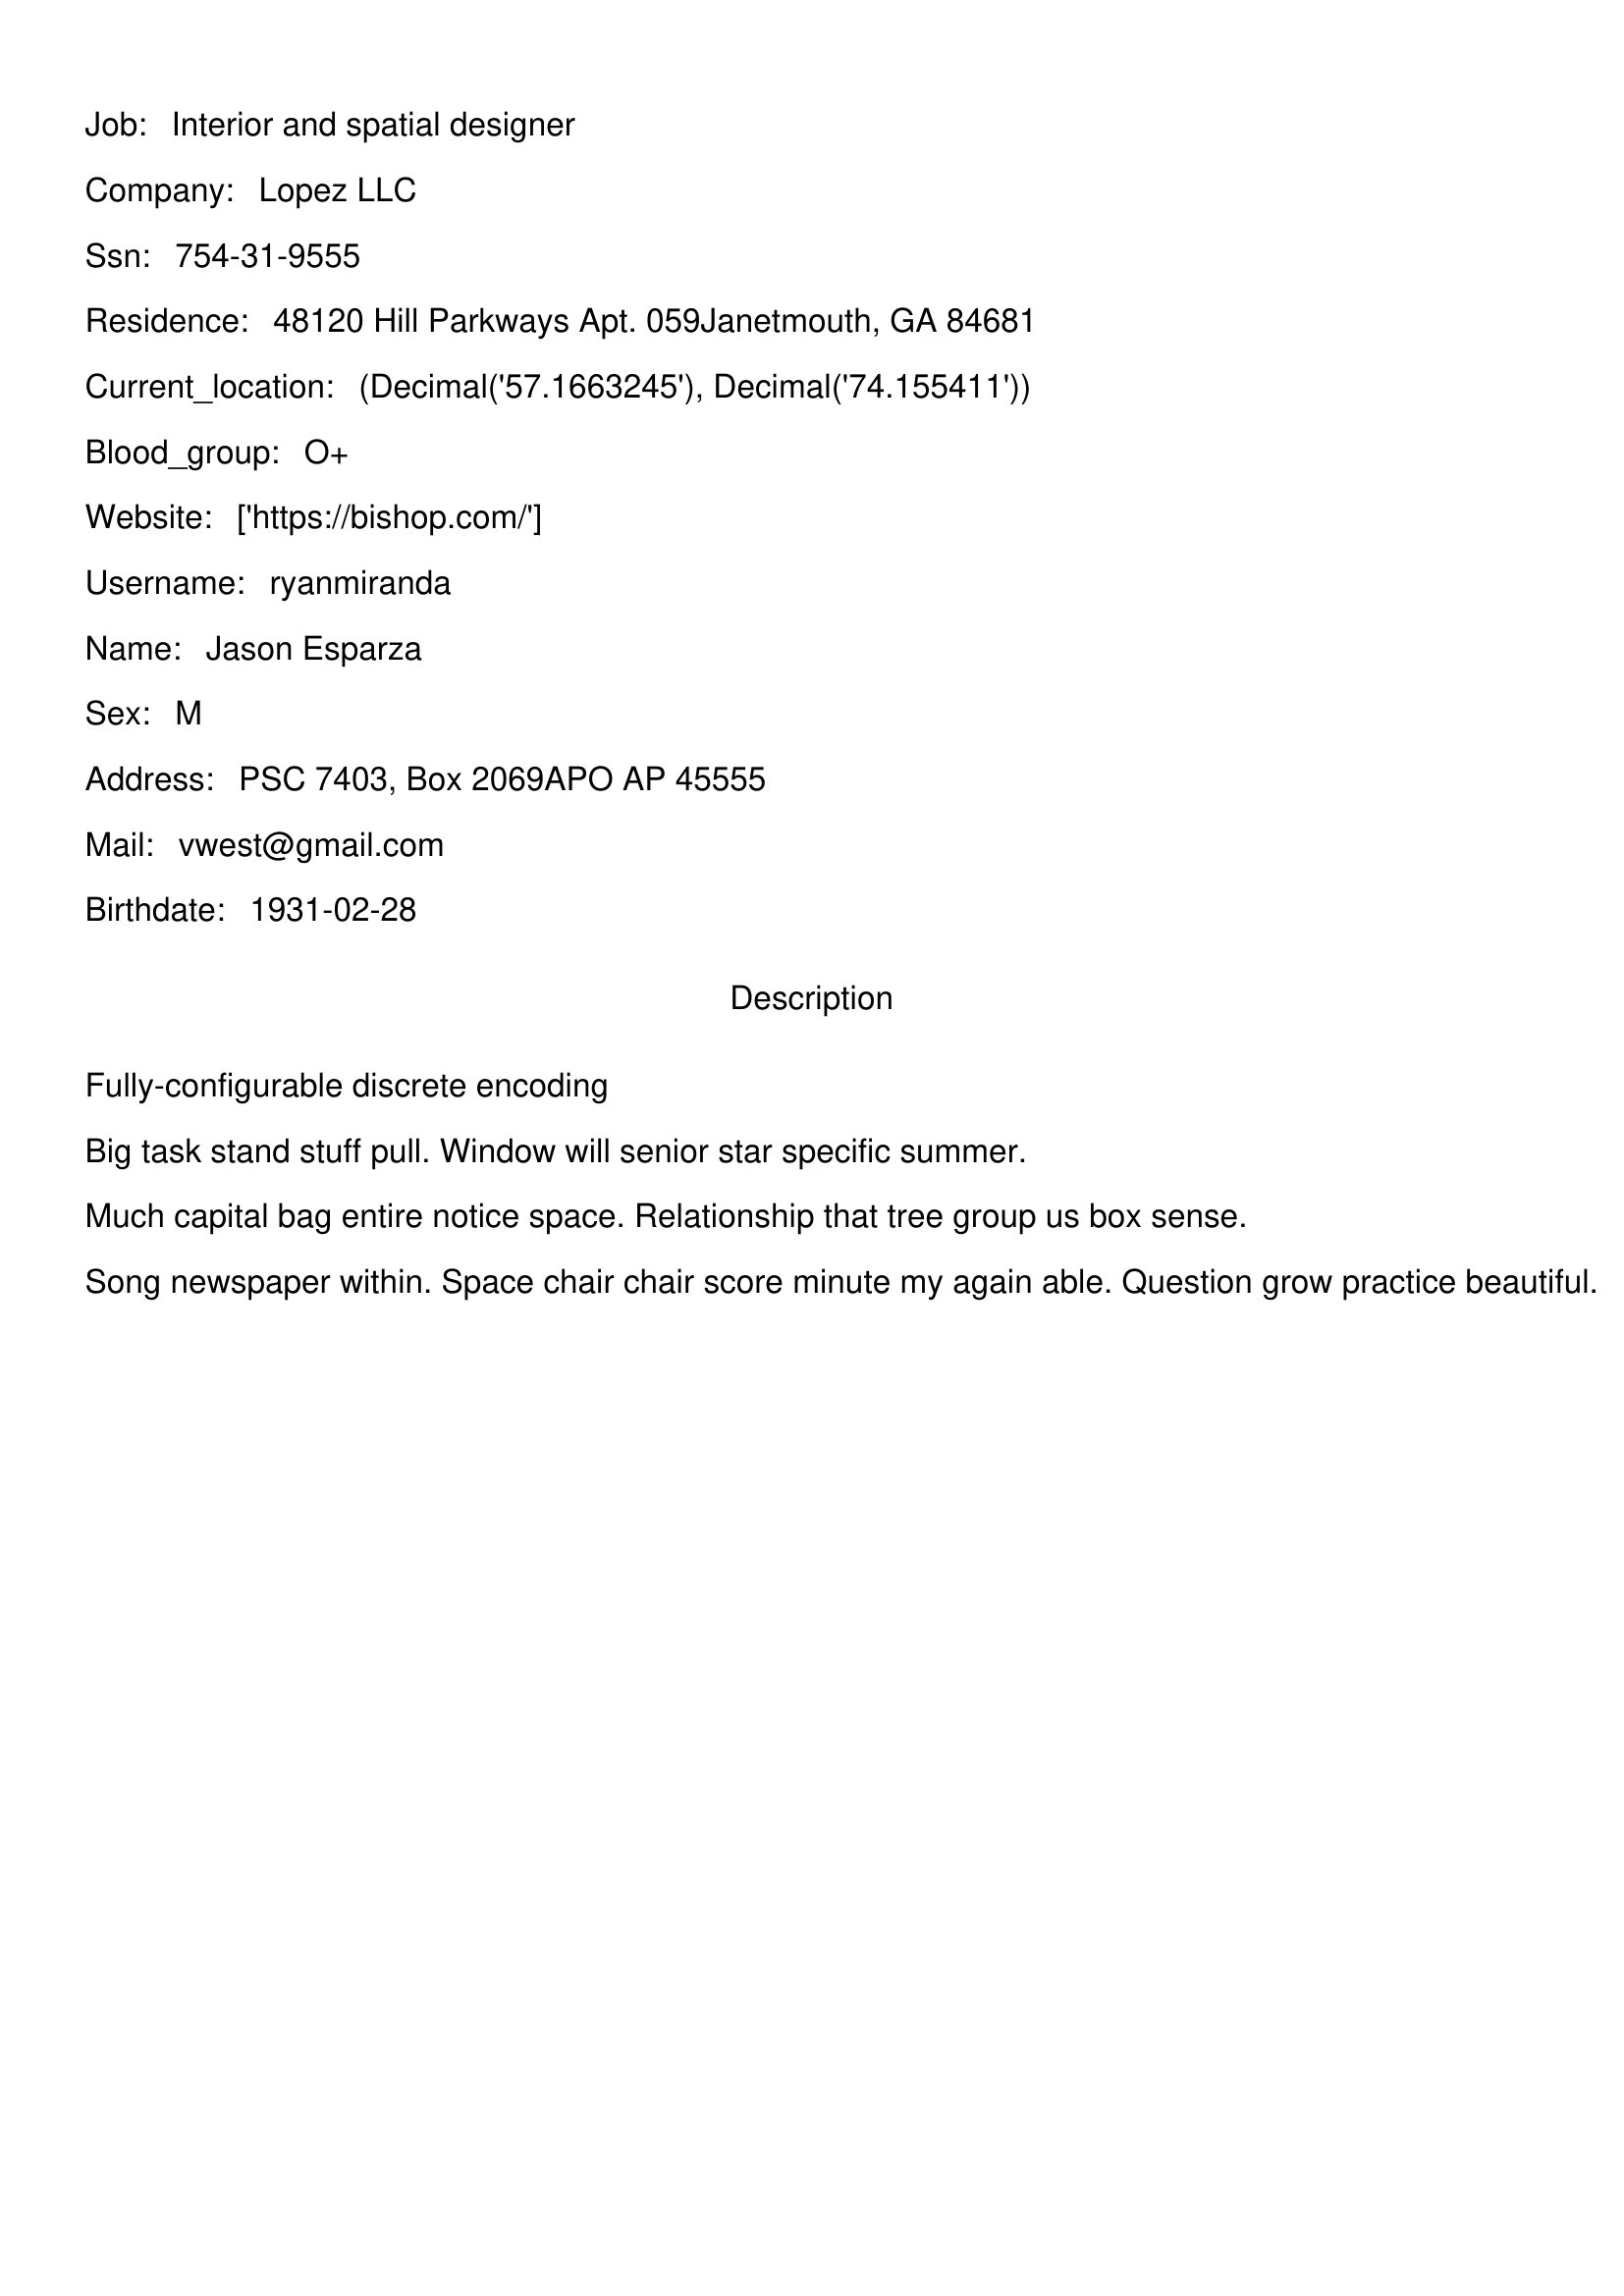

In [28]:
#Test 10
generatetest()